In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'creditcardfraud:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F310%2F23498%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240311%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240311T175543Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6a8f18a7b3468ed3918381a16f4d0ebe85a7c93559048bb8893f5e6689bd56259204e0c93f8987aa828be47cdf51194eed70578759683fe7d7e265191f8ff7e7e34c6eed0a451c5920a17d21bda4919f746459dccc4f3b951498c7d27c66af9a96843450eb1d58a2c121e31398290f5b1981900bd0e95a96c14a242eb0006ee3c694a1a809dbc0d5ddcacc3f75ad945ec6e1a41ee9136be1d2527fe7fff328d6c7fd01e4778c3824bf4933769290dd5de5289f6b59df2f5e6c7e24d72c3ae1d64b1306733d7bf75743b7caf03d9696facb7d033876f501dfe90f567cf08bce860ee5ea2bca073cf00fcad3c1ebcadfea48e4e513816a6b64d75d9bbf9c91d2d9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 69155672 bytes downloaded
Downloaded and uncompressed: creditcardfraud
Data source import complete.


## Importing the libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics
from sklearn.metrics import *
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import(InstanceHardnessThreshold)
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.pipeline import make_pipeline
from collections import Counter
import pylab
pylab.rcParams['figure.figsize'] = (8, 5)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import PrecisionRecallDisplay
import warnings
warnings.filterwarnings("ignore")
from scipy import stats

Read the data.

In [3]:
itogF=pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')


## Exploring the Credit Card Fraud dataset

In [4]:
# Let's look at the first 5 observations
itogF.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Let's look at the last 5 observations
itogF.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [6]:
# let's look at the shape of the data
itogF.shape

(284807, 31)

Target distribution "1" и "0" in column "Class", legal and fraudulent transactions, respectively, pieces
0: 284315
1: 492
Imbalance degree: 1: 577.88
 
Target distribution "1" и "0" in column "Class", legal and fraudulent transactions, respectively, %
Class
0    99.827251
1     0.172749
Name: Class, dtype: float64


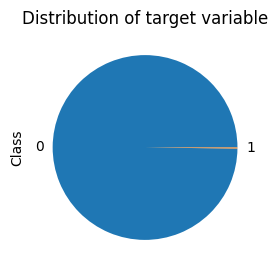

In [7]:
# Target distribution
print('Target distribution "1" и "0" in column "Class", legal and fraudulent transactions, respectively, pieces')
target_count = itogF['Class'].value_counts()
print('0:', target_count[0])
print('1:', target_count[1])
print('Imbalance degree:', '1:', round(target_count[0] / target_count[1], 2))
print (' ')
print('Target distribution "1" и "0" in column "Class", legal and fraudulent transactions, respectively, %')
print((itogF.groupby('Class')['Class'].count()/itogF['Class'].count())*100)


pylab.rcParams['figure.figsize'] = (4, 3)
target_count.plot(kind='pie', title='Distribution of target variable');


### The dataset in extremely imbalanced

## Data preprocessing

### Removing duplicates

In [8]:
duplicated_values = itogF[itogF.duplicated()]
duplicated_values

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
113,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
114,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
115,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282987,171288.0,1.912550,-0.455240,-1.750654,0.454324,2.089130,4.160019,-0.881302,1.081750,1.022928,...,-0.524067,-1.337510,0.473943,0.616683,-0.283548,-1.084843,0.073133,-0.036020,11.99,0
283483,171627.0,-1.464380,1.368119,0.815992,-0.601282,-0.689115,-0.487154,-0.303778,0.884953,0.054065,...,0.287217,0.947825,-0.218773,0.082926,0.044127,0.639270,0.213565,0.119251,6.82,0
283485,171627.0,-1.457978,1.378203,0.811515,-0.603760,-0.711883,-0.471672,-0.282535,0.880654,0.052808,...,0.284205,0.949659,-0.216949,0.083250,0.044944,0.639933,0.219432,0.116772,11.93,0
284191,172233.0,-2.667936,3.160505,-3.355984,1.007845,-0.377397,-0.109730,-0.667233,2.309700,-1.639306,...,0.391483,0.266536,-0.079853,-0.096395,0.086719,-0.451128,-1.183743,-0.222200,55.66,0


In [9]:
itogF.drop_duplicates(inplace=True)

In [10]:
itogF.shape

(283726, 31)

In [11]:
itogF['Class'].value_counts()

0    283253
1       473
Name: Class, dtype: int64

duplicates have been removed

### Checking for missing values and data types

In [12]:
itogF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283726 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    283726 non-null  float64
 1   V1      283726 non-null  float64
 2   V2      283726 non-null  float64
 3   V3      283726 non-null  float64
 4   V4      283726 non-null  float64
 5   V5      283726 non-null  float64
 6   V6      283726 non-null  float64
 7   V7      283726 non-null  float64
 8   V8      283726 non-null  float64
 9   V9      283726 non-null  float64
 10  V10     283726 non-null  float64
 11  V11     283726 non-null  float64
 12  V12     283726 non-null  float64
 13  V13     283726 non-null  float64
 14  V14     283726 non-null  float64
 15  V15     283726 non-null  float64
 16  V16     283726 non-null  float64
 17  V17     283726 non-null  float64
 18  V18     283726 non-null  float64
 19  V19     283726 non-null  float64
 20  V20     283726 non-null  float64
 21  V21     28

Dataset has no missing values

### Checking the correlation


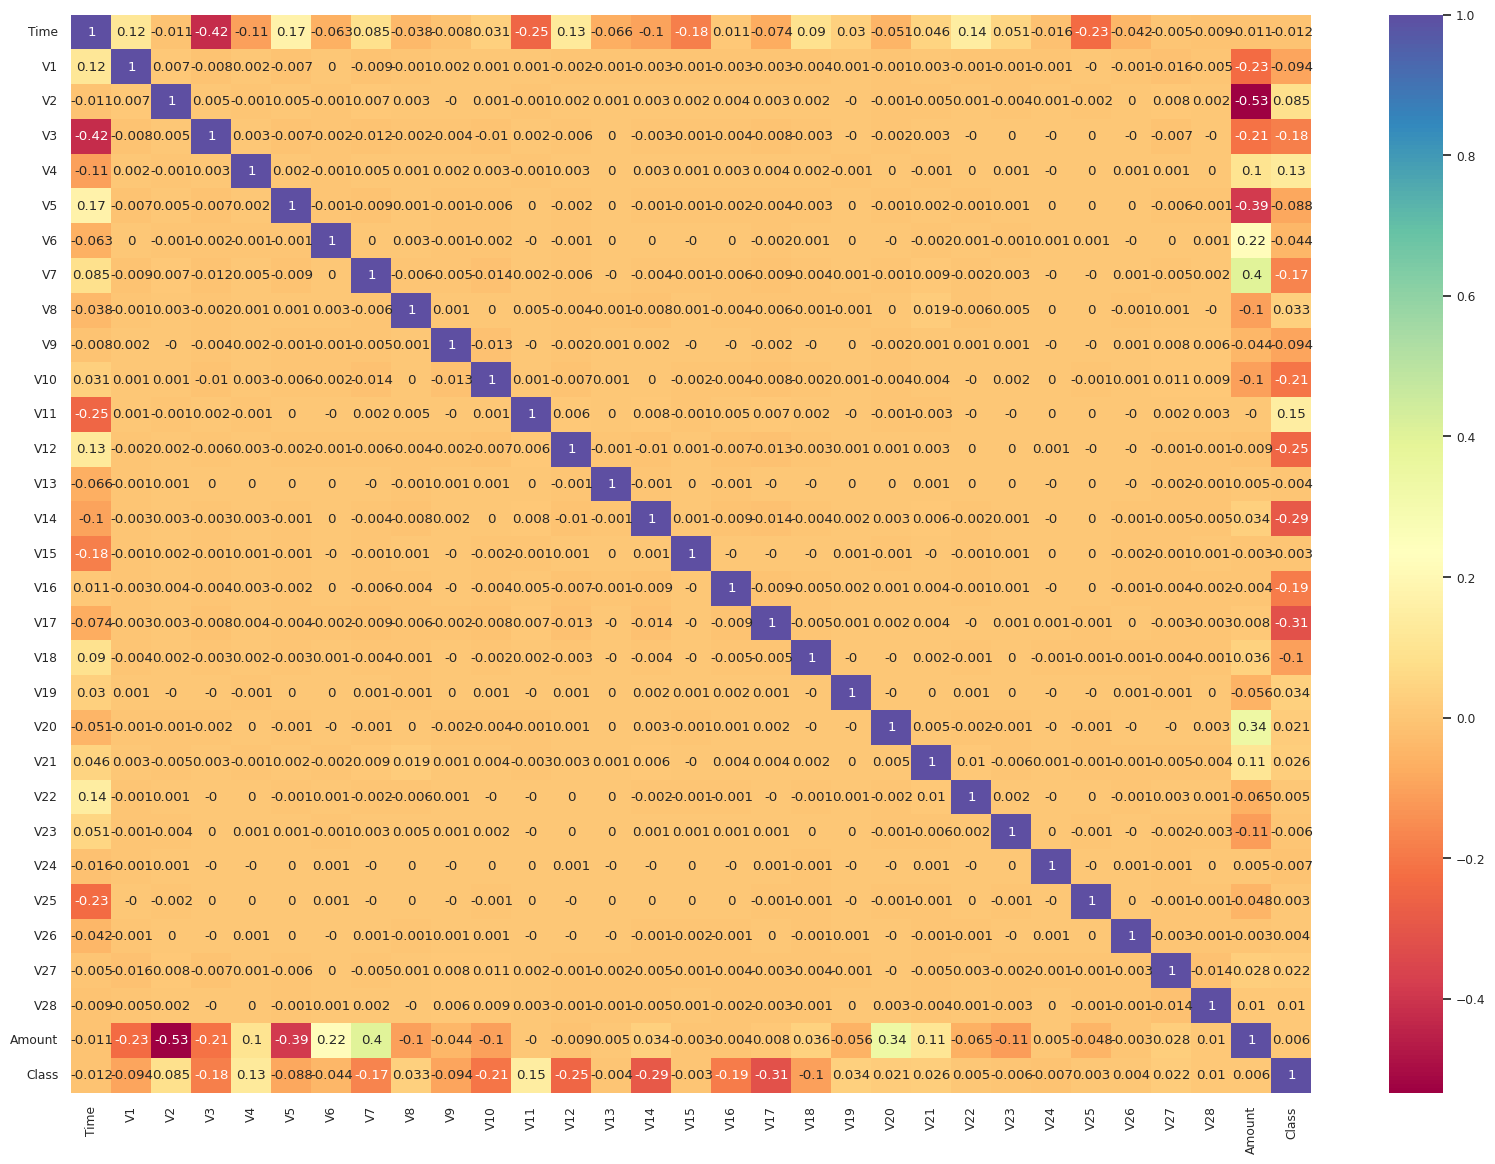

In [13]:
corr= round(itogF.corr(),3)
plt.figure(figsize=(20,14))
sns.set(font_scale=0.8)
sns.heatmap(corr, cmap = 'Spectral', annot = True)
plt.show()

### Let's look at the variables 'Time' and 'Amount'

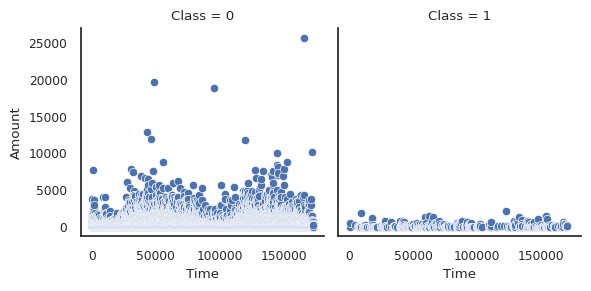

In [14]:
sns.set_style(style='white')
facet_grid = sns.FacetGrid(data=itogF, col='Class')
facet_grid.map(sns.scatterplot, 'Time', 'Amount', palette='Paired_r')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.show()

let's try to build a model without the 'Amount' variable so that the model does not depend on it

In [15]:
# Let's drop columns 'Time' and 'Amount'
itogF_copy = itogF.copy()
itogF_copy.drop('Time', axis = 1, inplace=True)
itogF_copy.drop('Amount', axis = 1, inplace=True)


In [16]:
itogF_copy.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### Splitting the data into dependend (у) and independent (Х) variables

In [17]:
y = itogF_copy['Class']
X = itogF_copy.drop(['Class'], axis=1)

In [18]:
# Let's look at the first 5 observations
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153


In [19]:
# Let's look at the descriptive statistics
X.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,-0.001441,...,-0.000264,0.000187,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547
std,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,1.076407,...,0.813379,0.769984,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027
min,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,...,-7.213527,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084
25%,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,-0.535578,...,-0.456289,-0.211469,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818
50%,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,-0.093237,...,0.003367,-0.062353,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288
75%,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,0.453619,...,0.458508,0.133207,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276
max,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,...,5.591971,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808


The data looks pre-scaled. No additional preprocessing is required.


In [20]:
# Plotting the distribution of a variable
# Accumulating all the column names under one variable
cols = list(X.columns.values)

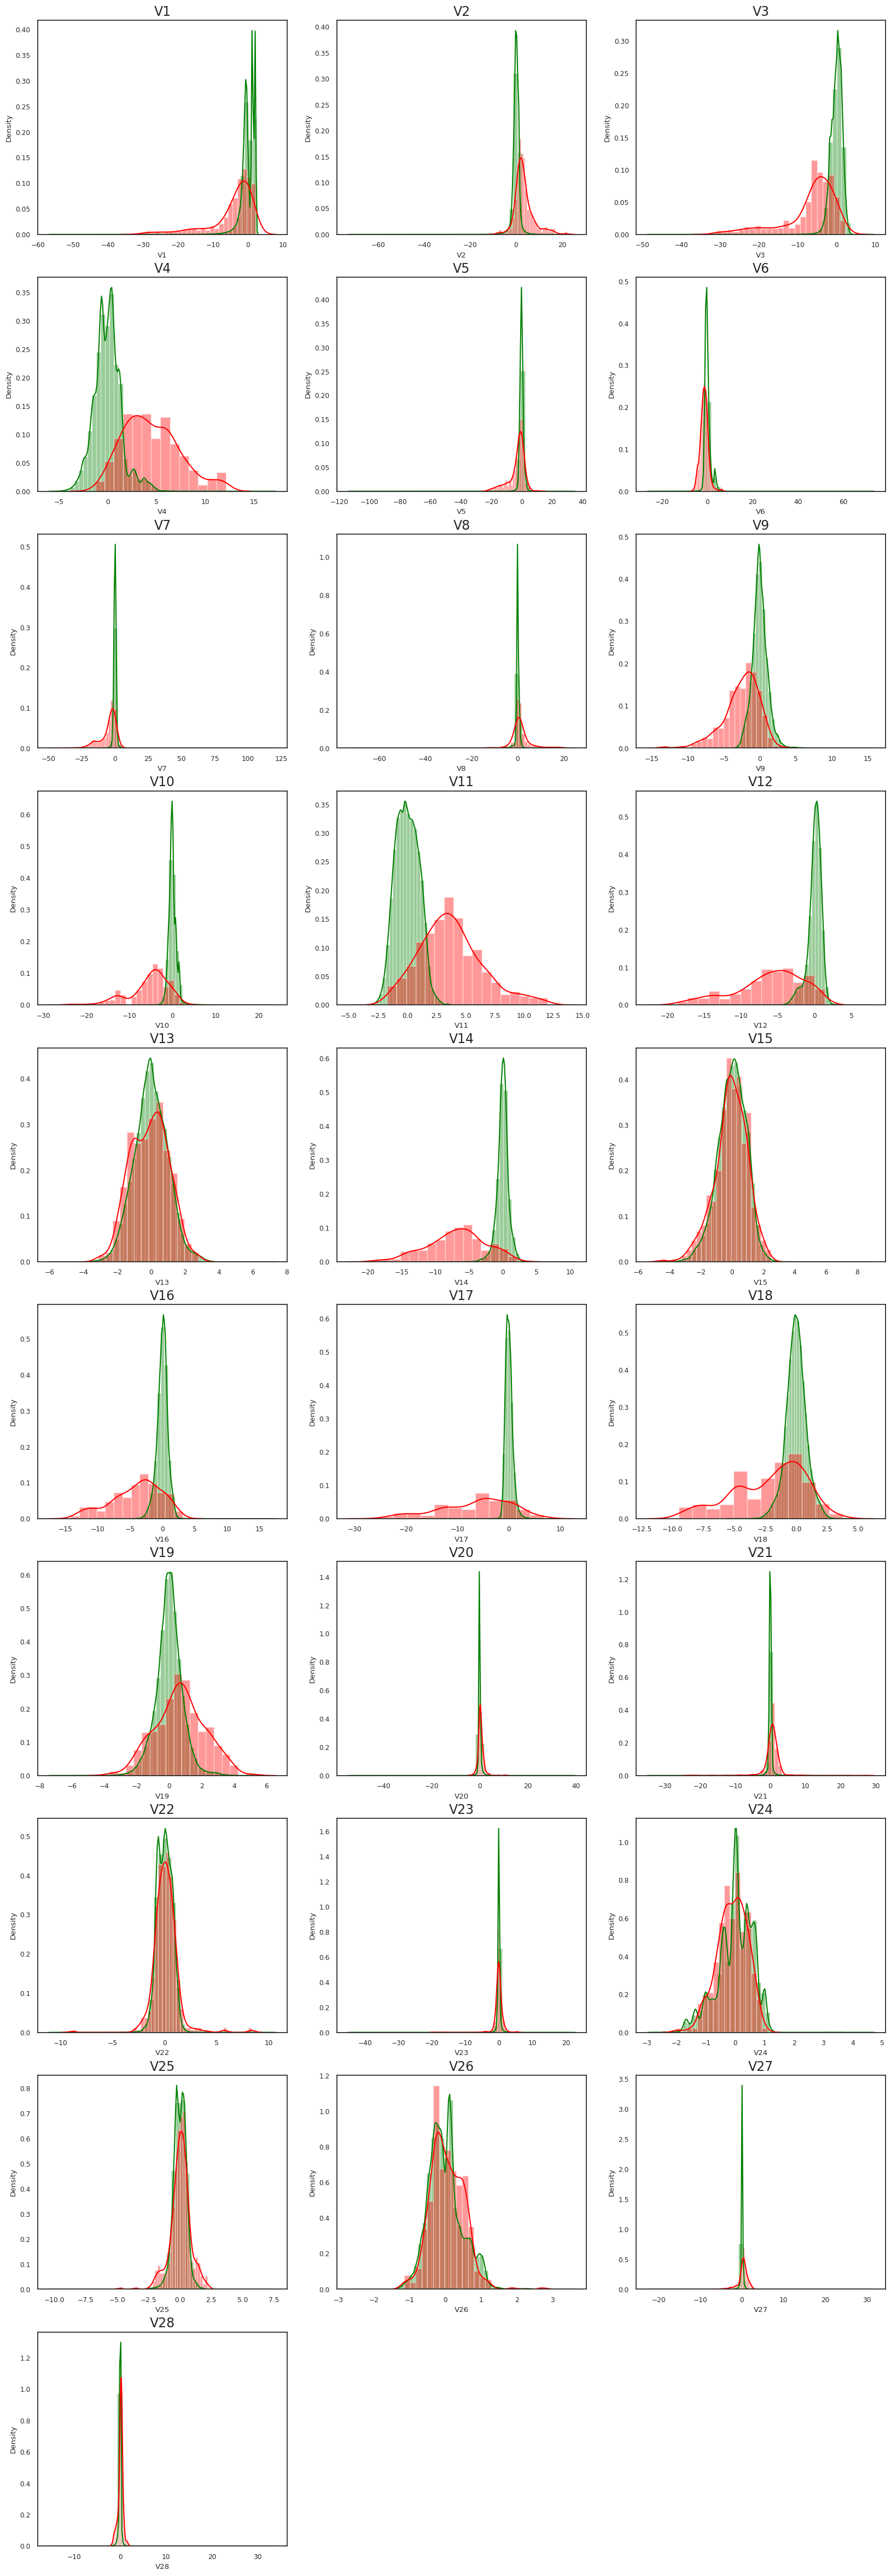

In [21]:
normal_records = itogF_copy.Class ==0
fraud_records = itogF_copy.Class == 1

plt.figure(figsize = (20, 60))
for n, col in enumerate(cols):
  plt.subplot(10,3, n+1)
  sns.distplot(X[col][normal_records], color='green')
  sns.distplot(X[col][fraud_records], color = 'red')
  plt.title(col, fontsize=17)

In [22]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [23]:
y.info()

<class 'pandas.core.series.Series'>
Int64Index: 283726 entries, 0 to 284806
Series name: Class
Non-Null Count   Dtype
--------------   -----
283726 non-null  int64
dtypes: int64(1)
memory usage: 4.3 MB


Splitting the data into train and test data

In [24]:
X_train, X_test, Y_train,Y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [25]:
print('X_train:', X_train.shape)
print('Y_train:', Y_train.shape)
print('X_test:', X_test.shape)
print('Y_test:', Y_test.shape)

X_train: (255353, 28)
Y_train: (255353,)
X_test: (28373, 28)
Y_test: (28373,)


In [26]:
X_train.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
50340,0.642632,-2.386717,0.220606,-1.041128,-1.953948,-0.302390,-0.596753,-0.145963,-1.786001,1.174708,...,-0.732991,0.501536,-0.085624,-0.821965,-0.163091,0.036139,-0.098478,-0.425025,-0.020542,0.099838
231956,-0.303349,1.077423,-0.439382,-0.474360,0.507029,-0.700396,0.925844,0.070086,-0.505994,-0.856738,...,0.328494,-0.048732,0.434505,1.236417,-0.180111,-0.585031,-0.312352,-0.123843,0.084584,0.154410


In [27]:
X_test.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
73573,0.471727,-2.300052,0.506669,-0.382747,-1.727818,0.613011,-0.844659,0.264561,-0.227545,0.465962,...,0.385617,0.862693,0.610903,0.818683,-0.488846,-0.250407,0.205917,-0.056039,-0.025159,0.080567
17063,0.769255,-0.404248,0.195493,1.617499,-0.474257,-0.543650,0.509890,-0.264398,0.129775,-0.213424,...,-0.086223,0.363751,0.018637,-0.217032,-0.303705,0.437461,0.684101,-0.369520,-0.013644,0.060992


In [28]:
Y_train.head(2)

50340     0
231956    0
Name: Class, dtype: int64

In [29]:
Y_test.head(2)

73573    0
17063    0
Name: Class, dtype: int64

In [30]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255353 entries, 50340 to 67057
Data columns (total 28 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      255353 non-null  float64
 1   V2      255353 non-null  float64
 2   V3      255353 non-null  float64
 3   V4      255353 non-null  float64
 4   V5      255353 non-null  float64
 5   V6      255353 non-null  float64
 6   V7      255353 non-null  float64
 7   V8      255353 non-null  float64
 8   V9      255353 non-null  float64
 9   V10     255353 non-null  float64
 10  V11     255353 non-null  float64
 11  V12     255353 non-null  float64
 12  V13     255353 non-null  float64
 13  V14     255353 non-null  float64
 14  V15     255353 non-null  float64
 15  V16     255353 non-null  float64
 16  V17     255353 non-null  float64
 17  V18     255353 non-null  float64
 18  V19     255353 non-null  float64
 19  V20     255353 non-null  float64
 20  V21     255353 non-null  float64
 21  V22    

In [31]:
Y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 255353 entries, 50340 to 67057
Series name: Class
Non-Null Count   Dtype
--------------   -----
255353 non-null  int64
dtypes: int64(1)
memory usage: 3.9 MB


In [32]:
Y_test.info()

<class 'pandas.core.series.Series'>
Int64Index: 28373 entries, 73573 to 73206
Series name: Class
Non-Null Count  Dtype
--------------  -----
28373 non-null  int64
dtypes: int64(1)
memory usage: 443.3 KB


In [33]:
target_count_Y_train =Y_train.value_counts()
target_count_0_Y_train = target_count_Y_train[0]
target_count_1_Y_train = target_count_Y_train[1]
print('Imbalance degree, train data:', '1:', round(target_count_0_Y_train / target_count_1_Y_train, 2))

target_count_Y_test =Y_test.value_counts()
target_count_0_Y_test = target_count_Y_test[0]
target_count_1_Y_test = target_count_Y_test[1]
print('Imbalance degree, test data:', '1:', round(target_count_0_Y_test / target_count_1_Y_test, 2))

Imbalance degree, train data: 1: 598.42
Imbalance degree, test data: 1: 602.68


#Data analysis

## Without creating or removing observations

### Logistic Regression

In [34]:
#from sklearn.linear_model import LogisticRegression

In [35]:
LR = LogisticRegression(random_state = 42)

In [36]:
LR.fit(X_train, Y_train)

LogisticRegression(random_state=42)

In [37]:
print('[[TN,   FP]')
print(' [FN,   TP]]')

[[TN,   FP]
 [FN,   TP]]


In [38]:
Y_pred_LR = LR.predict(X_test)
cm_LR = confusion_matrix(Y_test, Y_pred_LR)

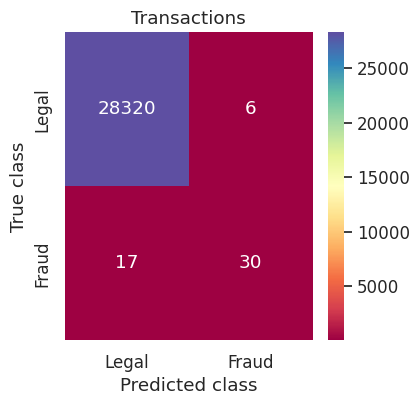

In [39]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_LR, xticklabels=LABELS, cmap = 'Spectral', yticklabels=LABELS, annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [40]:
Y_pred_proba_train_LR = LR.predict_proba(X_train)
roc_auc_score_Train_LR = roc_auc_score(Y_train, Y_pred_proba_train_LR[:,1])
print('Train set roc-auc: ', roc_auc_score_Train_LR)

Y_pred_proba_test_LR = LR.predict_proba(X_test)
roc_auc_score_Test_LR = roc_auc_score(Y_test, Y_pred_proba_test_LR[:,1])
print('Test set roc_auc: ', roc_auc_score_Test_LR)


Train set roc-auc:  0.9780522734935203
Test set roc_auc:  0.962901536968517


In [41]:
#from sklearn.metrics import PrecisionRecallDisplay

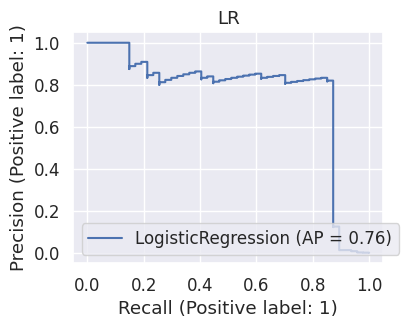

In [42]:
#sns.set_style(style='white')
display = PrecisionRecallDisplay.from_estimator(LR, X_test, Y_test)
_ = display.ax_.set_title("LR")

In [43]:
Y_test_LR = LR.predict_proba(X_test)[:,1]

In [44]:
# Area under the PR Curve

# first find preciion and recall various at various thresholds
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_LR)

# then using these values, determine the area under the curve
auc_logit_LR = auc(recall, precision)
print('Area under PR Curve LR: ', auc_logit_LR)

Area under PR Curve LR:  0.7579197452904789


In [45]:
# Average Precision Score
# logistic regression
ap_logit_LR = average_precision_score(Y_test, Y_test_LR)
print('Average Precision Logistic Regression: ', ap_logit_LR)


Average Precision Logistic Regression:  0.760409081894326


In [46]:
cr_LR= classification_report(Y_test, Y_pred_LR)
print('LR')
print(cr_LR)

LR
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28326
           1       0.83      0.64      0.72        47

    accuracy                           1.00     28373
   macro avg       0.92      0.82      0.86     28373
weighted avg       1.00      1.00      1.00     28373



### Logistic Regression + hyperparameter class_weight

In [47]:
params_grid = {"class_weight": [{0:1, 1:1}, {0:1, 1:5}, {0:1, 1:50},'balanced']}

In [48]:
grid_search = GridSearchCV(LR, params_grid, n_jobs = -1, cv=5, scoring = 'f1')

In [49]:
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 5},
                                          {0: 1, 1: 50}, 'balanced']},
             scoring='f1')

In [50]:
grid_search.best_params_

{'class_weight': {0: 1, 1: 5}}

In [51]:
LR_bestGrid=grid_search.best_estimator_

In [52]:
Y_pred_LR_class_weight = LR_bestGrid.predict(X_test)
cm_LR_class_weight = confusion_matrix(Y_test, Y_pred_LR_class_weight)

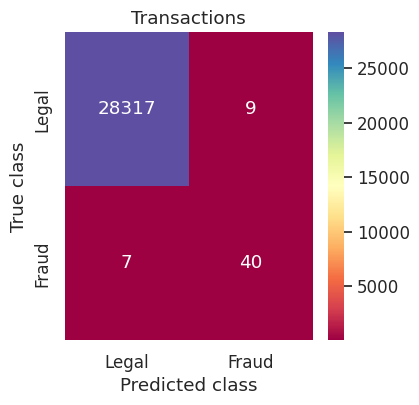

In [53]:
# Let's plot the confusion matrix
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_LR_class_weight, cmap= 'Spectral', xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Мetrics:

In [54]:
Y_pred_proba_train_LR_bestGrid = LR_bestGrid.predict_proba(X_train)
roc_auc_score_Train_LR_bestGrid = roc_auc_score(Y_train, Y_pred_proba_train_LR_bestGrid[:,1])
print('Train set LR roc-auc:', roc_auc_score_Train_LR_bestGrid)
print('Test set')
Y_pred_proba_test_LR_bestGrid = LR_bestGrid.predict_proba(X_test)
roc_auc_score_Test_LR_bestGrid = roc_auc_score(Y_test, Y_pred_proba_test_LR_bestGrid[:,1])
print('Test set LR roc_auc:', roc_auc_score_Test_LR_bestGrid)

Train set LR roc-auc: 0.9828232057079177
Test set
Test set LR roc_auc: 0.9718520388005305


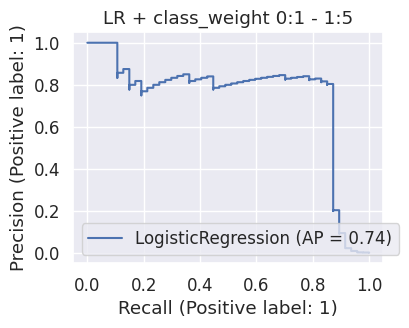

In [55]:
display = PrecisionRecallDisplay.from_estimator(LR_bestGrid, X_test, Y_test)
_ = display.ax_.set_title("LR + class_weight 0:1 - 1:5")

In [56]:
Y_test_LR_best_Grid = LR_bestGrid.predict_proba(X_test)[:,1]

In [57]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_LR_best_Grid)
auc_logit_LR_best_Grid = auc(recall, precision)
print('Area under PR Curve ', auc_logit_LR_best_Grid)


Area under PR Curve  0.7405951681655643


In [58]:
# Average Precision Score
ap_logit_LR_bestGrid = average_precision_score(Y_test, Y_test_LR_best_Grid)
ap_logit_LR_bestGrid

0.7439878387168932

In [59]:
cr_LR_bestGrid = classification_report(Y_test, Y_pred_LR_class_weight)
print('LR + class_weight: 0:1 - 1:5')
print(cr_LR_bestGrid)

LR + class_weight: 0:1 - 1:5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28326
           1       0.82      0.85      0.83        47

    accuracy                           1.00     28373
   macro avg       0.91      0.93      0.92     28373
weighted avg       1.00      1.00      1.00     28373



In [60]:
#from sklearn.ensemble import HistGradientBoostingClassifier

In [61]:
# let's set up the gradient boosting classifier with some parameters
clf_HGBC = HistGradientBoostingClassifier(loss='binary_crossentropy', learning_rate=0.1, random_state=0)

#determine the hyperparameter space
param_grid = dict(
    max_depth = stats.randint(5, 10),
    max_leaf_nodes= stats.randint(50, 200),
    min_samples_leaf = stats.randint(10, 200)
)

# set up the search
search = RandomizedSearchCV(
    clf_HGBC, # model
    param_grid, # hyperparam space
    scoring='roc_auc', #metric to optimize
    cv = 2, # To speed things up, we can choose more
    n_iter = 60, # we can choose less to speed things up, or more for best search
    random_state = 42,
    refit = True # this fit the model with the best hyperparams to the entire training set after the hyperparam search
)
# find best hyperparameters
search.fit(X_train, Y_train)

KeyboardInterrupt: 

In [ ]:
search.best_params_

In [ ]:
clf_HGBC_best =search.best_estimator_

In [ ]:
Y_pred_HGBC = clf_HGBC_best.predict(X_test)
cm_HGBC = confusion_matrix(Y_test, Y_pred_HGBC)

In [ ]:
#confusion matrix
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_HGBC, cmap = 'Spectral', xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:

Y_pred_proba_train_HGBC = clf_HGBC_best.predict_proba(X_train)
roc_auc_score_Train_HGBC = roc_auc_score(Y_train, Y_pred_proba_train_HGBC[:,1])
print('Train set roc-auc:', roc_auc_score_Train_HGBC)

Y_pred_proba_test_HGBC = clf_HGBC_best.predict_proba(X_test)
roc_auc_score_Test_HGBC = roc_auc_score(Y_test, Y_pred_proba_test_HGBC[:,1])
print('Test set roc_auc:', roc_auc_score_Test_HGBC)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(clf_HGBC_best, X_test, Y_test)
_ = display.ax_.set_title("HGBC")

In [ ]:
Y_test_HGBC = clf_HGBC_best.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_HGBC)
auc_logit_HGBC = auc(recall, precision)
print('Area under PR Curve', auc_logit_HGBC)

In [ ]:
# Average Precision Score
ap_logit_HGBC = average_precision_score(Y_test, Y_test_HGBC)
print('Аverage Precision Score', ap_logit_HGBC)

In [ ]:
cr_HGBC = classification_report(Y_test, Y_pred_HGBC)
print('HGBC')
print(cr_HGBC)

### Hist Gradient Boosting Classifier + manual hyperparametes selection

In [ ]:
#from sklearn.ensemble import HistGradientBoostingClassifier
clf_HGBC = HistGradientBoostingClassifier(loss = 'binary_crossentropy', learning_rate=0.1, max_leaf_nodes=150, min_samples_leaf = 150, max_depth=15, random_state=0)



In [ ]:
clf_HGBC.fit(X_train, Y_train)

In [ ]:
Y_pred_HGBC = clf_HGBC.predict(X_test)
cm_HGBC = confusion_matrix(Y_test, Y_pred_HGBC)

In [ ]:
#confusion matrix:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_HGBC, cmap = 'Spectral', xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Metrics:

In [ ]:

Y_pred_proba_train_HGBC = clf_HGBC.predict_proba(X_train)
roc_auc_score_Train_HGBC = roc_auc_score(Y_train, Y_pred_proba_train_HGBC[:,1])
print('Train set roc-auc:', roc_auc_score_Train_HGBC)

Y_pred_proba_test_HGBC = clf_HGBC.predict_proba(X_test)
roc_auc_score_Test_HGBC = roc_auc_score(Y_test, Y_pred_proba_test_HGBC[:,1])
print('Test set roc_auc:', roc_auc_score_Test_HGBC)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(clf_HGBC, X_test, Y_test)
_ = display.ax_.set_title("HGBC")

In [ ]:
Y_test_HGBC = clf_HGBC.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_HGBC)
auc_logit_HGBC = auc(recall, precision)
print('Area under PR Curve', auc_logit_HGBC)

In [ ]:
# Average Precision Score
ap_logit_HGBC = average_precision_score(Y_test, Y_test_HGBC)
print('Аverage Precision Score', ap_logit_HGBC)

In [ ]:
cr_HGBC = classification_report(Y_test, Y_pred_HGBC)
print('HGBC')
print(cr_HGBC)

In [ ]:
# setting the class_weight parameter with a different ratio of weights by class

sample_weights_balanced = compute_sample_weight(class_weight = 'balanced', y = Y_train)
sample_weight1_5 = compute_sample_weight(class_weight = {0: 1, 1:1.5}, y = Y_train)
sample_weight2 = compute_sample_weight(class_weight = {0: 1, 1:2}, y = Y_train)
sample_weight3 = compute_sample_weight(class_weight = {0: 1, 1:3}, y = Y_train)
sample_weight4 = compute_sample_weight(class_weight = {0: 1, 1:4}, y = Y_train)
sample_weight5 = compute_sample_weight(class_weight = {0: 1, 1:5}, y = Y_train)
sample_weight6 = compute_sample_weight(class_weight = {0: 1, 1:6}, y = Y_train)
sample_weight10 = compute_sample_weight(class_weight = {0: 1, 1:10}, y = Y_train)
sample_weights_0_5_10 = compute_sample_weight(class_weight = {0:0.5, 1:10}, y = Y_train)
sample_weight50 = compute_sample_weight(class_weight = {0: 1, 1:50}, y = Y_train)


### Hist Gradient Boosting Classifier + sample_weight

In [ ]:
my_model_clf_HGBC = clf_HGBC.fit(X_train, Y_train, sample_weight = sample_weight5)

In [ ]:
Y_pred_my_model_HGBC = my_model_clf_HGBC.predict(X_test)
cm_my_model_HGBC = confusion_matrix(Y_test, Y_pred_my_model_HGBC)

In [ ]:
# confusion matrix:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_my_model_HGBC, cmap = 'Spectral', xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Metrics:

In [ ]:
Y_pred_proba_train_HGBC_1_5 = my_model_clf_HGBC.predict_proba(X_train)
roc_auc_score_Train_HGBC_1_5 = roc_auc_score(Y_train, Y_pred_proba_train_HGBC_1_5[:,1])
print('Train set roc-auc: ', roc_auc_score_Train_HGBC_1_5)

Y_pred_proba_test_HGBC_1_5 = my_model_clf_HGBC.predict_proba(X_test)
roc_auc_score_Test_HGBC_1_5 = roc_auc_score(Y_test, Y_pred_proba_test_HGBC_1_5[:,1])
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_1_5)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(my_model_clf_HGBC, X_test, Y_test)
_ = display.ax_.set_title("HGBC + sample_weight 0:1 - 1:5")

In [ ]:
Y_test_HGBC_1_5 = my_model_clf_HGBC.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_HGBC_1_5)
auc_logit_HGBC_1_5 = auc(recall, precision)
print('Area under PR Curve', auc_logit_HGBC_1_5)

In [ ]:
# Average Precision Score
ap_logit_HGBC_1_5 = average_precision_score(Y_test, Y_test_HGBC_1_5)
print('Аverage Precision Score', ap_logit_HGBC_1_5)

In [ ]:
cr_HGBC_1_5 = classification_report(Y_test, Y_pred_my_model_HGBC)
print('HGBC + sample_weight 0:1 - 1:5')
print(cr_HGBC_1_5)

### HistGradientBoostingClassifier + samlple_weight + RandomizedSearch

In [ ]:
my_model_clf_HGBC_RandSearch = clf_HGBC_best.fit(X_train, Y_train, sample_weight = sample_weight2)

In [ ]:
Y_pred_my_model_HGBC_RandSearch = my_model_clf_HGBC_RandSearch.predict(X_test)
cm_my_model_HGBC_RandSearch = confusion_matrix(Y_test, Y_pred_my_model_HGBC_RandSearch)

In [ ]:
# confusion matrix:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_my_model_HGBC_RandSearch, cmap = 'Spectral', xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Metrics:

In [ ]:
Y_pred_proba_train_HGBC_1_2 = my_model_clf_HGBC_RandSearch.predict_proba(X_train)
roc_auc_score_Train_HGBC_1_2 = roc_auc_score(Y_train, Y_pred_proba_train_HGBC_1_2[:,1])
print('Train set roc-auc: ', roc_auc_score_Train_HGBC_1_2)

Y_pred_proba_test_HGBC_1_2 = my_model_clf_HGBC_RandSearch.predict_proba(X_test)
roc_auc_score_Test_HGBC_1_2 = roc_auc_score(Y_test, Y_pred_proba_test_HGBC_1_2[:,1])
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_1_2)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(my_model_clf_HGBC_RandSearch, X_test, Y_test)
_ = display.ax_.set_title("HGBC + sample_weight 0:1 - 1:2")

In [ ]:
Y_test_HGBC_1_2 = my_model_clf_HGBC_RandSearch.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_HGBC_1_2)
auc_logit_HGBC_1_2 = auc(recall, precision)
print('Area under PR Curve ', auc_logit_HGBC_1_2)

In [ ]:
# Average Precision Score
ap_logit_HGBC_1_2 = average_precision_score(Y_test, Y_test_HGBC_1_2)
print('Аverage Precision Score', ap_logit_HGBC_1_2)

In [ ]:
cr_HGBC_1_2 = classification_report(Y_test, Y_pred_my_model_HGBC_RandSearch)
print('HGBC + sample_weight 0:1 - 1:2')
print(cr_HGBC_1_2)

### Hist Gragient Boosting Classifier + choosing class_weight by using GridSearch

In [ ]:
# determine the values we want to check
params_grid = {"class_weight": [{0:1, 1:1}, {0:1, 1:4}, {0:1, 1:5}, {0:1, 1:6}, {0:1, 1:10}, 'balanced' ]}


In [ ]:
grid_search = GridSearchCV(clf_HGBC_best, params_grid, n_jobs = -1, cv=5, scoring = "roc_auc")

In [ ]:
grid_search.fit(X_train, Y_train)

In [ ]:
grid_search.best_params_

In [ ]:
HGBC_weighted=grid_search.best_estimator_

In [ ]:
Y_pred_HGBC_weighted = HGBC_weighted.predict(X_test)
cm_HGBC_weighted = confusion_matrix(Y_test, Y_pred_HGBC_weighted)
cm_HGBC_weighted

### ExtraTreesClassifier +  RandomizedSearch for best hyperparametes values

In [ ]:
clf_ETC = ExtraTreesClassifier(random_state = 0)

In [ ]:
param_grid = dict(
    n_estimators = stats.randint(50, 200),
    min_samples_split = stats.randint(0, 3),
    max_depth = stats.randint(1, 10)
)

In [ ]:
search = RandomizedSearchCV(
    clf_ETC,
    param_grid,
    scoring = 'roc_auc',
    cv = 2,
    n_iter = 60,
    random_state = 5,
    refit=True
)
search.fit(X_train, Y_train)

In [ ]:
search.best_params_

In [ ]:
clf_ETC_best =search.best_estimator_

In [ ]:
Y_pred_ETC_best = clf_ETC_best.predict(X_test)
cm_ETC_best = confusion_matrix(Y_test, Y_pred_ETC_best)

In [ ]:
#confusion matrix
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_ETC_best, cmap = 'Spectral', xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### ExtraTrees Classifier + manual hyperparameters selection

Not every time GridSearch and RandomizedSearch give the best result. We can try to choose hyperparameters manually

In [ ]:
#from sklearn.ensemble import ExtraTreesClassifier
clf_ETC = ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
clf_ETC.fit(X_train, Y_train)


In [ ]:
Y_pred_ETC = clf_ETC.predict(X_test)
cm_ETC = confusion_matrix(Y_test, Y_pred_ETC)

In [ ]:
# confusion matrix
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_ETC, xticklabels=LABELS, cmap = 'Spectral', yticklabels=LABELS, annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Metrics:

In [ ]:
Y_pred_proba_train_ETC = clf_ETC.predict_proba(X_train)
roc_auc_score_Train_ETC = roc_auc_score(Y_train, Y_pred_proba_train_ETC[:,1])
print('Train set roc-auc: ', roc_auc_score_Train_ETC)

Y_pred_proba_test_ETC = clf_ETC.predict_proba(X_test)
roc_auc_score_Test_ETC = roc_auc_score(Y_test, Y_pred_proba_test_ETC[:,1])
print('Test set roc_auc: ', roc_auc_score_Test_ETC)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(clf_ETC, X_test, Y_test)
_ = display.ax_.set_title("ETC")

In [ ]:
Y_test_ETC = clf_ETC.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_ETC)
auc_logit_ETC = auc(recall, precision)
print('Area under PR Curve ETC', auc_logit_ETC)

In [ ]:
# Average Precision Score
ap_logit_ETC = average_precision_score(Y_test, Y_test_ETC)
print('Аverage Precision Score', ap_logit_ETC)

In [ ]:
cr_ETC = classification_report(Y_test, Y_pred_ETC)
print('ETC')
print(cr_ETC)

### ExtraTreesClassifier +  sample_weight

In [ ]:
my_model_clf = clf_ETC.fit(X_train, Y_train, sample_weight = sample_weight5)

In [ ]:
Y_pred_my_model_ETC = my_model_clf.predict(X_test)
cm_my_model_ETC = confusion_matrix(Y_test, Y_pred_my_model_ETC)

In [ ]:
#confusion matrix
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_my_model_ETC, xticklabels=LABELS, cmap = 'Spectral', yticklabels=LABELS, annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Metriсs:

In [ ]:
Y_pred_proba_train_ETC_1_5 = my_model_clf.predict_proba(X_train)
roc_auc_score_Train_ETC_1_5 = roc_auc_score(Y_train, Y_pred_proba_train_ETC_1_5[:,1])
print('Train set roc-auc: ', roc_auc_score_Train_ETC_1_5)

Y_pred_proba_test_ETC_1_5 = my_model_clf.predict_proba(X_test)
roc_auc_score_Test_ETC_1_5 = roc_auc_score(Y_test, Y_pred_proba_test_ETC_1_5[:,1])
print('Test set roc_auc: ', roc_auc_score_Test_ETC_1_5)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(my_model_clf, X_test, Y_test)
_ = display.ax_.set_title("ETC + sample_weight 0:1 = 1:5 ")

In [ ]:
Y_test_ETC_1_5 = my_model_clf.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_ETC_1_5)
auc_logit_ETC_1_5 = auc(recall, precision)
print('Area under PR Curve ETC', auc_logit_ETC_1_5)

In [ ]:
# Average Precision Score
ap_logit_ETC_1_5 = average_precision_score(Y_test, Y_test_ETC_1_5)
print('Аverage Precision Score', ap_logit_ETC_1_5)

In [ ]:
cr_ETC_1_5 = classification_report(Y_test, Y_pred_my_model_ETC)
print('ETC+ sample_weight 0:1 = 1:5')
print(cr_ETC_1_5)

# UNDERSAMPLING methods for imbalanced data


## Condensed Nearest Neighbour

In [ ]:
#from imblearn.under_sampling import CondensedNearestNeighbour


In [ ]:
cnn = CondensedNearestNeighbour(sampling_strategy = 'auto', random_state = 0, n_neighbors=1, n_jobs = -1)
x_cnn, y_cnn = cnn.fit_resample(X_train, Y_train) # transformed data ~ 6 hours on CPU

In [ ]:
#X_cnn_csv = pd.DataFrame(data=x_cnn)
#Y_cnn_csv = pd.DataFrame(data=y_cnn)

In [ ]:

#X_cnn_csv.to_csv('/kaggle/working/X_cnn.csv', sep='\t', encoding='utf-8', index=False)

In [ ]:
#Y_cnn_csv.to_csv('/kaggle/working/Y_cnn.csv', sep='\t', encoding='utf_8', index=False)

In [ ]:
#x_cnn=pd.read_csv('/content/drive/MyDrive/X_cnn.csv', sep ='\t', encoding ='utf-8')
#y_cnn=pd.read_csv('/content/drive/MyDrive/Y_cnn.csv', sep ='\t', encoding ='utf-8')

In [ ]:
X_train.shape, Y_train.shape # original data

In [ ]:
x_cnn.shape, y_cnn.shape # transformed data

In [ ]:
Y_train.value_counts()

In [ ]:
y_cnn.value_counts()

In [ ]:
target_count_y_cnn = y_cnn.value_counts()
target_count_0_y_cnn = target_count_y_cnn[0]
target_count_1_y_cnn = target_count_y_cnn[1]
print('Imbalance degree:', '1:', round(target_count_0_y_cnn / target_count_1_y_cnn, 2))


In [ ]:
y_cnn.info()

In [ ]:
Y_train.info()

In [ ]:
# Convert to the pandas series data type to display the obtained values on the plot
y_cnn_s = y_cnn.squeeze()

In [ ]:
y_cnn_s.info()

In [ ]:
#Let's check on the variables 'V4' and 'V9'. We can choose different variables
sns.set_style(style='white')
sns.scatterplot(data=X_train, x='V4', y='V9', hue=Y_train, alpha=0.5)
plt.title('Original dataset')

In [ ]:
sns.set_style(style='white')
sns.scatterplot(data=x_cnn, x='V4', y='V9', hue=y_cnn_s, alpha=0.5)
plt.title('Undersampled by Condenced Nearest Neighbours dataset')

### Logistic Regression + Condensed Nearest Neighbour

In [ ]:
LR_cnn = LogisticRegression(random_state = 42)

In [ ]:
LR_cnn.fit(x_cnn, y_cnn)

In [ ]:
Y_pred_LR_cnn = LR_cnn.predict(X_test)
cm_LR_cnn = confusion_matrix(Y_test, Y_pred_LR_cnn)

In [ ]:
# confusion matrix
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_LR_cnn, xticklabels=LABELS, cmap = 'Spectral', yticklabels=LABELS, annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Metrics:

In [ ]:
Y_pred_proba_train_LR_cnn = LR_cnn.predict_proba(x_cnn)
roc_auc_score_Train_LR_cnn = roc_auc_score(y_cnn, Y_pred_proba_train_LR_cnn[:,1])
print('Train set roc-auc:', roc_auc_score_Train_LR_cnn)

Y_pred_proba_test_LR_cnn = LR_cnn.predict_proba(X_test)
roc_auc_score_Test_LR_cnn = roc_auc_score(Y_test, Y_pred_proba_test_LR_cnn[:,1])
print('Test set roc_auc:', roc_auc_score_Test_LR_cnn)


In [ ]:
LR_disp_cnn = PrecisionRecallDisplay.from_estimator(LR_cnn, X_test, Y_test)

In [ ]:
Y_test_LR_cnn = LR_cnn.predict_proba(X_test)[:,1]

In [ ]:
# Area under the PR Curve

# first find preciion and recall various at various thresholds
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_LR_cnn)

# then using these values, determine the area under the curve
auc_logit_LR_cnn = auc(recall, precision)
print('Area under PR Curve LR: ', auc_logit_LR_cnn)

In [ ]:
# Average Precision Score
# logistic regression
ap_logit_LR_cnn = average_precision_score(Y_test, Y_test_LR_cnn)
print('Average Precision Logistic Regression: ', ap_logit_LR_cnn)


In [ ]:
cr_LR_cnn = classification_report(Y_test, Y_pred_LR_cnn)
print('LR cnn')
print(cr_LR_cnn)

### Logistic Regression + Condensed Nearest Neighbour + hyperparameter class_weight

In [ ]:
#our dataset is still unbalanced. Let's check if we can get the best result using hyperparameter class_weight

In [ ]:
LR_cnn_weighted = LogisticRegression(random_state = 42, class_weight = {0:1, 1:2})

In [ ]:
LR_cnn_weighted.fit(x_cnn, y_cnn)

In [ ]:
Y_pred_LR_cnn_c_w = LR_cnn_weighted.predict(X_test)
cm_LR_cnn_c_w = confusion_matrix(Y_test, Y_pred_LR_cnn_c_w)

In [ ]:
# confusion matrix
LABELS = ['Обычные', 'Мошеннические']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_LR_cnn_c_w, xticklabels=LABELS, cmap = 'Spectral', yticklabels=LABELS, annot=True, fmt='d')
plt.title('Матрица ошибок по операциям')
plt.ylabel('Реальность')
plt.xlabel('Прогноз')
plt.show()

Metrics:

In [ ]:
#roc-auc score
Y_pred_proba_train_LR_c_w_cnn = LR_cnn_weighted.predict_proba(x_cnn)
roc_auc_score_Train_LR_c_w_cnn = roc_auc_score(y_cnn, Y_pred_proba_train_LR_c_w_cnn[:,1])
print('Train set LR roc-auc:', roc_auc_score_Train_LR_c_w_cnn)
Y_pred_proba_test_LR_c_w_cnn = LR_cnn_weighted.predict_proba(X_test)
roc_auc_score_Test_LR_c_w_cnn = roc_auc_score(Y_test, Y_pred_proba_test_LR_c_w_cnn[:,1])
print('Test set LR roc_auc:', roc_auc_score_Test_LR_c_w_cnn)

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(LR_cnn_weighted, X_test, Y_test)
_ = display.ax_.set_title("LR + CondensedNearestNeighbour + class_weight = 1:2")

In [ ]:
Y_test_LR_cnn_c_w = LR_cnn_weighted.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_LR_cnn_c_w)
auc_logit_LR_cnn_c_w = auc(recall, precision)
print('Area under PR Curve', auc_logit_LR_cnn_c_w)


In [ ]:
# Average Precision Score
ap_logit_LR_cnn_c_w = average_precision_score(Y_test, Y_test_LR_cnn_c_w)
ap_logit_LR_cnn_c_w

In [ ]:
cr_LR_cnn_c_w = classification_report(Y_test, Y_pred_LR_cnn_c_w)
print('LR + cnn + class_weight: 0:1 - 1:2')
print(cr_LR_cnn_c_w)

### Hist Gradient Boosting Classifier + CondensedNearestNeighbour

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
clf_HGBC_cnn = HistGradientBoostingClassifier(loss = 'binary_crossentropy', learning_rate=0.1, max_leaf_nodes=150, min_samples_leaf = 150, max_depth=15, random_state=0)
clf_HGBC_cnn.fit(x_cnn, y_cnn)

In [ ]:
Y_pred_HGBC_cnn = clf_HGBC_cnn.predict(X_test)
cm_HGBC_cnn = confusion_matrix(Y_test, Y_pred_HGBC_cnn)

In [ ]:
# confusion matrix:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_HGBC_cnn, xticklabels=LABELS, cmap = 'Spectral', yticklabels=LABELS, annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Metrics:

In [ ]:
Y_pred_proba_train_HGBC_cnn = clf_HGBC_cnn.predict_proba(x_cnn)
roc_auc_score_Train_HGBC_cnn = roc_auc_score(y_cnn, Y_pred_proba_train_HGBC_cnn[:,1])
print('Train set roc-auc: ', roc_auc_score_Train_HGBC_cnn)

Y_pred_proba_test_HGBC_cnn = clf_HGBC_cnn.predict_proba(X_test)
roc_auc_score_Test_HGBC_cnn = roc_auc_score(Y_test, Y_pred_proba_test_HGBC_cnn[:,1])
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_cnn)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(clf_HGBC_cnn, X_test, Y_test)
_ = display.ax_.set_title("HGBC + cnn")

In [ ]:
Y_test_HGBC_cnn = clf_HGBC_cnn.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_HGBC_cnn)
auc_logit_HGBC_cnn = auc(recall, precision)
print('Area under PR Curve ', auc_logit_HGBC_cnn)

In [ ]:
# Average Precision Score
ap_logit_HGBC_cnn = average_precision_score(Y_test, Y_test_HGBC_cnn)
print('Аverage Precision Score', ap_logit_HGBC_cnn)

In [ ]:
cr_HGBC_cnn = classification_report(Y_test, Y_pred_HGBC_cnn)
print('HGBC + cnn')
print(cr_HGBC_cnn)

### HistGradientBoostingClassifier Condensed Nearest Neighbour sample_weight

In [ ]:
# Let's try to use class_weight additionally

sample_weights_balanced = compute_sample_weight(class_weight = 'balanced', y = y_cnn)
sample_weight2 = compute_sample_weight(class_weight = {0: 1, 1:2}, y = y_cnn)
sample_weight3 = compute_sample_weight(class_weight = {0: 1, 1:3}, y = y_cnn)
sample_weight5 = compute_sample_weight(class_weight = {0: 1, 1:5}, y = y_cnn)

In [ ]:
my_model_clf_HGBC_cnn = clf_HGBC_cnn.fit(x_cnn, y_cnn, sample_weight = sample_weight3)

In [ ]:
Y_pred_HGBC_cnn_c_w = my_model_clf_HGBC_cnn.predict(X_test)
cm_HGBC_cnn_c_w = confusion_matrix(Y_test, Y_pred_HGBC_cnn_c_w)

In [ ]:
# Confusion matrix
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_HGBC_cnn_c_w, xticklabels=LABELS, cmap = 'Spectral', yticklabels=LABELS, annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Metrics:

In [ ]:
Y_pred_proba_train_HGBC_cnn_c_w = my_model_clf_HGBC_cnn.predict_proba(x_cnn)
roc_auc_score_Train_HGBC_cnn_c_w = roc_auc_score(y_cnn, Y_pred_proba_train_HGBC_cnn_c_w[:,1])
print('Train set roc-auc:', roc_auc_score_Train_HGBC_cnn_c_w)

Y_pred_proba_test_HGBC_cnn_c_w = my_model_clf_HGBC_cnn.predict_proba(X_test)
roc_auc_score_Test_HGBC_cnn_c_w = roc_auc_score(Y_test, Y_pred_proba_test_HGBC_cnn_c_w[:,1])
print('Test set roc_auc:', roc_auc_score_Test_HGBC_cnn_c_w)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(my_model_clf_HGBC_cnn, X_test, Y_test)
_ = display.ax_.set_title("HGBC + cnn + sample_weight 0:1 - 1:3")

In [ ]:
Y_test_HGBC_c_w_cnn = my_model_clf_HGBC_cnn.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_HGBC_c_w_cnn)
auc_logit_HGBC_c_w_cnn = auc(recall, precision)
print('Area under PR Curve ', auc_logit_HGBC_c_w_cnn)

In [ ]:
# Average Precision Score
ap_logit_HGBC_c_w_cnn = average_precision_score(Y_test, Y_test_HGBC_c_w_cnn)
print('Аverage Precision Score', ap_logit_HGBC_c_w_cnn)

In [ ]:
cr_HGBC_c_w_cnn = classification_report(Y_test, Y_pred_HGBC_cnn_c_w)
print('HGBC + cnn + sample_weight 0:1 - 1:3')
print(cr_HGBC_c_w_cnn)

### Extra Trees Classifier + Condensed Nearest Neighbour

In [ ]:
#from sklearn.ensemble import ExtraTreesClassifier
clf_ETC_cnn = ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
clf_ETC_cnn.fit(x_cnn, y_cnn)


In [ ]:
Y_pred_ETC_cnn = clf_ETC_cnn.predict(X_test)
cm_ETC_cnn = confusion_matrix(Y_test, Y_pred_ETC_cnn)

In [ ]:
# confusion matrix
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_ETC_cnn, xticklabels=LABELS, cmap = 'Spectral', yticklabels=LABELS, annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Metrics:

In [ ]:
Y_pred_proba_train_ETC_cnn = clf_ETC_cnn.predict_proba(x_cnn)
roc_auc_score_Train_ETC_cnn = roc_auc_score(y_cnn, Y_pred_proba_train_ETC_cnn[:,1])
print('Train set roc-auc: ', roc_auc_score_Train_ETC_cnn)

Y_pred_proba_test_ETC_cnn = clf_ETC_cnn.predict_proba(X_test)
roc_auc_score_Test_ETC_cnn = roc_auc_score(Y_test, Y_pred_proba_test_ETC_cnn[:,1])
print('Test set roc_auc: ', roc_auc_score_Test_ETC_cnn)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(clf_ETC_cnn, X_test, Y_test)
_ = display.ax_.set_title("ETC + cnn")

In [ ]:
Y_test_ETC_cnn = clf_ETC_cnn.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_ETC_cnn)
auc_logit_ETC_cnn = auc(recall, precision)
print('Area under PR Curve ', auc_logit_ETC_cnn)

In [ ]:
# Average Precision Score
ap_logit_ETC_cnn = average_precision_score(Y_test, Y_test_ETC_cnn)
print('Аverage Precision Score', ap_logit_ETC_cnn)

In [ ]:
cr_ETC_cnn = classification_report(Y_test, Y_pred_ETC_cnn)
print('ETC + cnn')
print(cr_ETC_cnn)

### Extra Trees Classifier + Condenced Nearest Neighbour + Sample_weight

In [ ]:
my_model_clf_ETC_cnn = clf_ETC_cnn.fit(x_cnn, y_cnn, sample_weight = sample_weight3)

In [ ]:
Y_pred_ETC_cnn_c_w = my_model_clf_ETC_cnn.predict(X_test)
cm_ETC_cnn_c_w = confusion_matrix(Y_test, Y_pred_ETC_cnn_c_w)

In [ ]:
# confusion matrix
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_ETC_cnn_c_w, xticklabels=LABELS, cmap = 'Spectral', yticklabels=LABELS, annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
Y_pred_proba_train_ETC_cnn_c_w = my_model_clf_ETC_cnn.predict_proba(x_cnn)
roc_auc_score_Train_ETC_cnn_c_w = roc_auc_score(y_cnn, Y_pred_proba_train_ETC_cnn_c_w[:,1])
print('Train set roc-auc:', roc_auc_score_Train_ETC_cnn_c_w)

Y_pred_proba_test_ETC_cnn_c_w = my_model_clf_ETC_cnn.predict_proba(X_test)
roc_auc_score_Test_ETC_cnn_c_w = roc_auc_score(Y_test, Y_pred_proba_test_ETC_cnn_c_w[:,1])
print('Test set roc_auc:', roc_auc_score_Test_ETC_cnn_c_w)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(my_model_clf_ETC_cnn, X_test, Y_test)
_ = display.ax_.set_title("ETC + cnn + sample_weight 0:1 - 1:3")

In [ ]:
Y_test_ETC_c_w_cnn = my_model_clf_ETC_cnn.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_ETC_c_w_cnn)
auc_logit_ETC_c_w_cnn = auc(recall, precision)
print('Area under PR Curve', auc_logit_ETC_c_w_cnn)

In [ ]:
# Average Precision Score
ap_logit_ETC_c_w_cnn = average_precision_score(Y_test, Y_test_ETC_c_w_cnn)
print('Аverage Precision Score', ap_logit_ETC_c_w_cnn)

In [ ]:
cr_ETC_c_w_cnn = classification_report(Y_test, Y_pred_ETC_cnn_c_w)
print('ETC + sample_weight 0:1 - 1:3')
print(cr_ETC_c_w_cnn)

## Tomek Links

In [ ]:
#from imblearn.under_sampling import TomekLinks
#from sklearn.metrics import roc_auc_score

In [ ]:
tl = TomekLinks(sampling_strategy='auto', #undersamples only the majority class
                n_jobs=-1)
x_tl, y_tl = tl.fit_resample(X_train, Y_train)

In [ ]:
#X_tl_csv = pd.DataFrame(data=x_tl)
#Y_tl_csv = pd.DataFrame(data=y_tl)

In [ ]:
#X_tl_csv.to_csv('/content/drive/MyDrive/X_TL.csv', sep='\t', encoding='utf-8', index=False)

In [ ]:
#Y_tl_csv.to_csv('/content/drive/MyDrive/Y_TL.csv', sep='\t', encoding='utf_8', index=False)

In [ ]:
#x_tl=pd.read_csv('/content/drive/MyDrive/X_TL.csv', sep ='\t', encoding ='utf-8')
#y_tl=pd.read_csv('/content/drive/MyDrive/Y_TL.csv', sep ='\t', encoding ='utf-8')

In [ ]:
X_train.shape, Y_train.shape

In [ ]:
x_tl.shape, y_tl.shape

In [ ]:
target_count_y_tl = y_tl.value_counts()
target_count_0_y_tl = target_count_y_tl[0]
target_count_1_y_tl = target_count_y_tl[1]
print('Imbalance degree:', '1:', round(target_count_0_y_tl / target_count_1_y_tl, 2))


In [ ]:
Y_train.value_counts()

In [ ]:
y_tl.value_counts()

In [ ]:
# Convert to the pandas series data type to display the obtained values on the plot
y_tl_s = y_tl.squeeze()

In [ ]:
sns.set_style(style='white')
sns.scatterplot(data=X_train, x='V4', y='V9', hue=Y_train, alpha=0.5)
plt.title('Original dataset')

In [ ]:
sns.set_style(style='white')
sns.scatterplot(data=x_tl, x='V4', y='V9', hue=y_tl_s, alpha=0.5)
plt.title('Undersampled by Tomek Links dataset')

### Logistic Regression + Tomek Links

In [ ]:
LR_TomekLinks = LogisticRegression(random_state = 42)

In [ ]:
LR_TomekLinks.fit(x_tl, y_tl)

In [ ]:
Y_pred_LR_tl = LR_TomekLinks.predict(X_test)
cm_LR_tl = confusion_matrix(Y_test, Y_pred_LR_tl)

In [ ]:
# confusion matrix:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_LR_tl, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Metrics:

In [ ]:
Y_pred_proba_train_LR_tl = LR_TomekLinks.predict_proba(x_tl)
roc_auc_score_Train_LR_tl = roc_auc_score(y_tl, Y_pred_proba_train_LR_tl[:,1])
print('Train set roc-auc:', roc_auc_score_Train_LR_tl)

Y_pred_proba_test_LR_tl = LR_TomekLinks.predict_proba(X_test)
roc_auc_score_Test_LR_tl = roc_auc_score(Y_test, Y_pred_proba_test_LR_tl[:,1])
print('Test set roc_auc:', roc_auc_score_Test_LR_tl)


In [ ]:
LR_disp_tl = PrecisionRecallDisplay.from_estimator(LR_TomekLinks, X_test, Y_test)

In [ ]:
Y_test_LR_tl = LR_TomekLinks.predict_proba(X_test)[:,1]

In [ ]:
# Area under the PR Curve

# first find preciion and recall various at various thresholds
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_LR_tl)

# then using these values, determine the area under the curve
auc_logit_LR_tl = auc(recall, precision)
print('Area under PR Curve: ', auc_logit_LR_tl)

In [ ]:
# Average Precision Score
# logistic regression
ap_logit_LR_tl = average_precision_score(Y_test, Y_test_LR_tl)
print('Average Precision Score: ', ap_logit_LR_tl)


In [ ]:
cr_LR_tl = classification_report(Y_test, Y_pred_LR_tl)
print('LR tl')
print(cr_LR_tl)

### Logistic Regression + Tomek Links + class_weight = 1:5

In [ ]:
LR_TomekLinks_weighted = LogisticRegression(random_state = 42, class_weight = {0:1, 1:5})

In [ ]:
LR_TomekLinks_weighted.fit(x_tl, y_tl)

In [ ]:
Y_pred_LR_tl_1_5 = LR_TomekLinks_weighted.predict(X_test)
cm_LR_tl_1_5 = confusion_matrix(Y_test, Y_pred_LR_tl_1_5)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_LR_tl_1_5, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
#roc-auc score
Y_pred_proba_train_LR_1_5_tl = LR_TomekLinks_weighted.predict_proba(x_tl)
roc_auc_score_Train_LR_1_5_tl = roc_auc_score(y_tl, Y_pred_proba_train_LR_1_5_tl[:,1])
print('Train set LR roc-auc:', roc_auc_score_Train_LR_1_5_tl)
Y_pred_proba_test_LR_1_5_tl = LR_TomekLinks_weighted.predict_proba(X_test)
roc_auc_score_Test_LR_1_5_tl = roc_auc_score(Y_test, Y_pred_proba_test_LR_1_5_tl[:,1])
print('Test set LR roc_auc:', roc_auc_score_Test_LR_1_5_tl)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(LR_TomekLinks_weighted, X_test, Y_test)
_ = display.ax_.set_title("LR + TomekLinks + class_weight = 1:5")

In [ ]:
Y_test_LR_tl_1_5 = LR_TomekLinks_weighted.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_LR_tl_1_5)
auc_logit_LR_tl_1_5 = auc(recall, precision)
print('Area under PR Curve', auc_logit_LR_tl_1_5)


In [ ]:
# Average Precision Score
ap_logit_LR_tl_1_5 = average_precision_score(Y_test, Y_test_LR_tl_1_5)
ap_logit_LR_tl_1_5

In [ ]:
cr_LR_tl_1_5 = classification_report(Y_test, Y_pred_LR_tl_1_5)
print('LR + tl + class_weight: 0:1 - 1:5')
print(cr_LR_tl_1_5)

### Hist Gradient Boosting Classifier + Tomek Links

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
clf_HGBC_tl = HistGradientBoostingClassifier(random_state = 42)
#clf_HGBC_tl = HistGradientBoostingClassifier(loss = 'binary_crossentropy', learning_rate=0.1, max_leaf_nodes=150, min_samples_leaf = 150, max_depth=15, random_state=0) - the result is worse, use default hp.
clf_HGBC_tl.fit(x_tl, y_tl)


In [ ]:
Y_pred_HGBC_tl = clf_HGBC_tl.predict(X_test)
cm_HGBC_tl = confusion_matrix(Y_test, Y_pred_HGBC_tl)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_HGBC_tl, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:

Y_pred_proba_train_HGBC_tl = clf_HGBC_tl.predict_proba(x_tl)
roc_auc_score_Train_HGBC_tl = roc_auc_score(y_tl, Y_pred_proba_train_HGBC_tl[:,1])
print('Train set roc-auc:', roc_auc_score_Train_HGBC_tl)

Y_pred_proba_test_HGBC_tl = clf_HGBC_tl.predict_proba(X_test)
roc_auc_score_Test_HGBC_tl = roc_auc_score(Y_test, Y_pred_proba_test_HGBC_tl[:,1])
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_tl)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(clf_HGBC_tl, X_test, Y_test)
_ = display.ax_.set_title("HGBC + tl")

In [ ]:
Y_test_HGBC_tl = clf_HGBC_tl.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_HGBC_tl)
auc_logit_HGBC_tl = auc(recall, precision)
print('Area under PR Curve ', auc_logit_HGBC_tl)

In [ ]:
# Average Precision Score
ap_logit_HGBC_tl = average_precision_score(Y_test, Y_test_HGBC_tl)
print('Аverage Precision Score', ap_logit_HGBC_tl)

In [ ]:
cr_HGBC_tl = classification_report(Y_test, Y_pred_HGBC_tl)
print('HGBC + tl')
print(cr_HGBC_tl)

In [ ]:
# # Let's try to use class_weight additionally

sample_weights_balanced = compute_sample_weight(class_weight = 'balanced', y = y_tl)
sample_weight2 = compute_sample_weight(class_weight = {0: 1, 1:2}, y = y_tl)
sample_weight3 = compute_sample_weight(class_weight = {0: 1, 1:3}, y = y_tl)
sample_weight4 = compute_sample_weight(class_weight = {0: 1, 1:4}, y = y_tl)
sample_weight5 = compute_sample_weight(class_weight = {0: 1, 1:5}, y = y_tl)
sample_weight10 = compute_sample_weight(class_weight = {0: 1, 1:10}, y = y_tl)
sample_weights_0_5_10 = compute_sample_weight(class_weight = {0:0.5, 1:10}, y = y_tl)
sample_weight50 = compute_sample_weight(class_weight = {0: 1, 1:50}, y = y_tl)

### Hist Gradient Boosting Classifier + Tomek Links + sample_weight = 1:5

In [ ]:
my_model_clf_HGBC_tl = clf_HGBC_tl.fit(x_tl, y_tl, sample_weight = sample_weight5)

In [ ]:
Y_pred_HGBC_tl_1_5 = my_model_clf_HGBC_tl.predict(X_test)
cm_HGBC_tl_1_5 = confusion_matrix(Y_test, Y_pred_HGBC_tl_1_5)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_HGBC_tl_1_5, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
Y_pred_proba_train_HGBC_tl_1_5 = my_model_clf_HGBC_tl.predict_proba(x_tl)
roc_auc_score_Train_HGBC_tl_1_5 = roc_auc_score(y_tl, Y_pred_proba_train_HGBC_tl_1_5[:,1])
print('Train set roc-auc:', roc_auc_score_Train_HGBC_tl_1_5)

Y_pred_proba_test_HGBC_tl_1_5 = my_model_clf_HGBC_tl.predict_proba(X_test)
roc_auc_score_Test_HGBC_tl_1_5 = roc_auc_score(Y_test, Y_pred_proba_test_HGBC_tl_1_5[:,1])
print('Test set roc_auc:', roc_auc_score_Test_HGBC_tl_1_5)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(my_model_clf_HGBC_tl, X_test, Y_test)
_ = display.ax_.set_title("HGBC + tl + sample_weight 0:1 - 1:5")

In [ ]:
Y_test_HGBC_1_5_tl = my_model_clf_HGBC_tl.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_HGBC_1_5_tl)
auc_logit_HGBC_1_5_tl = auc(recall, precision)
print('Area under PR Curve ', auc_logit_HGBC_1_5_tl)

In [ ]:
# Average Precision Score
ap_logit_HGBC_1_5_tl = average_precision_score(Y_test, Y_test_HGBC_1_5_tl)
print('Аverage Precision Score', ap_logit_HGBC_1_5_tl)

In [ ]:
cr_HGBC_1_5_tl = classification_report(Y_test, Y_pred_HGBC_tl_1_5)
print('HGBC + tl + sample_weight 0:1 - 1:5')
print(cr_HGBC_1_5_tl)

### Extra Trees Classifier + Tomek Links

In [ ]:
#from sklearn.ensemble import ExtraTreesClassifier
clf_ETC_tl = ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
clf_ETC_tl.fit(x_tl, y_tl)


In [ ]:
Y_pred_ETC_tl = clf_ETC_tl.predict(X_test)
cm_ETC_tl = confusion_matrix(Y_test, Y_pred_ETC_tl)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_ETC_tl, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
Y_pred_proba_train_ETC_tl = clf_ETC_tl.predict_proba(x_tl)
roc_auc_score_Train_ETC_tl = roc_auc_score(y_tl, Y_pred_proba_train_ETC_tl[:,1])
print('Train set roc-auc:', roc_auc_score_Train_ETC_tl)

Y_pred_proba_test_ETC_tl = clf_ETC_tl.predict_proba(X_test)
roc_auc_score_Test_ETC_tl = roc_auc_score(Y_test, Y_pred_proba_test_ETC_tl[:,1])
print('Test set roc_auc:', roc_auc_score_Test_ETC_tl)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(clf_ETC_tl, X_test, Y_test)
_ = display.ax_.set_title("ETC + tl")

In [ ]:
Y_test_ETC_tl = clf_ETC_tl.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_ETC_tl)
auc_logit_ETC_tl = auc(recall, precision)
print('Area under PR Curve ', auc_logit_ETC_tl)

In [ ]:
# Average Precision Score
ap_logit_ETC_tl = average_precision_score(Y_test, Y_test_ETC_tl)
print('Аverage Precision Score', ap_logit_ETC_tl)

In [ ]:
cr_ETC_tl = classification_report(Y_test, Y_pred_ETC_tl)
print('ETC + tl')
print(cr_ETC_tl)

### Extra Trees Classifier + Tomek Links + sample_weight

In [ ]:
my_model_clf_tl_c_w = clf_ETC.fit(x_tl, y_tl, sample_weight = sample_weight3)

In [ ]:
Y_pred_ETC_tl_my_model = my_model_clf_tl_c_w.predict(X_test)
cm_ETC_tl_my_model = confusion_matrix(Y_test, Y_pred_ETC_tl_my_model)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_ETC_tl_my_model, xticklabels=LABELS, cmap = 'Spectral', yticklabels=LABELS, annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
Y_pred_proba_train_ETC_tl_c_w = my_model_clf_tl_c_w.predict_proba(x_tl)
roc_auc_score_Train_ETC_tl_c_w = roc_auc_score(y_tl, Y_pred_proba_train_ETC_tl_c_w[:,1])
print('Train set roc-auc:', roc_auc_score_Train_ETC_tl_c_w)

Y_pred_proba_test_ETC_tl_c_w = my_model_clf_tl_c_w.predict_proba(X_test)
roc_auc_score_Test_ETC_tl_c_w = roc_auc_score(Y_test, Y_pred_proba_test_ETC_tl_c_w[:,1])
print('Test set roc_auc:', roc_auc_score_Test_ETC_tl_c_w)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(my_model_clf_tl_c_w, X_test, Y_test)
_ = display.ax_.set_title("ETC + tl + sample_weight 0:1 - 1:3")

In [ ]:
Y_test_ETC_c_w_tl = my_model_clf_tl_c_w.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_ETC_c_w_tl)
auc_logit_ETC_c_w_tl = auc(recall, precision)
print('Area under PR Curve', auc_logit_ETC_c_w_tl)

In [ ]:
# Average Precision Score
ap_logit_ETC_c_w_tl = average_precision_score(Y_test, Y_test_ETC_c_w_tl)
print('Аverage Precision Score', ap_logit_ETC_c_w_tl)

In [ ]:
cr_ETC_c_w_tl = classification_report(Y_test, Y_pred_ETC_tl_my_model)
print('ETC + sample_weight 0:1 - 1:3')
print(cr_ETC_c_w_tl)

## Edited Nearest Neighbours

In [ ]:
#from imblearn.under_sampling import EditedNearestNeighbours

In [ ]:
# use for majoriti class,
# number of neighbours = 3,
# all neighbors must be of the same class as the observations under study
#transform only the majority class
enn = EditedNearestNeighbours(n_neighbors=3, kind_sel = 'all', n_jobs=-1, sampling_strategy='auto')
x_enn, y_enn = enn.fit_resample(X_train, Y_train)

In [ ]:
X_train.shape, Y_train.shape

In [ ]:
x_enn.shape, y_enn.shape

In [ ]:
Y_train.value_counts(), y_enn.value_counts()

In [ ]:
target_count_y_enn = y_enn.value_counts()
target_count_0_y_enn = target_count_y_enn[0]
target_count_1_y_enn = target_count_y_enn[1]
print('Imbalance degree:', '1:', round(target_count_0_y_enn / target_count_1_y_enn, 2))


In [ ]:
y_enn_s = y_enn.squeeze()

In [ ]:
sns.set_style(style='white')
sns.scatterplot(data=X_train, x='V4', y='V9', hue=Y_train, alpha=0.5)
plt.title('Original dataset')

In [ ]:
sns.set_style(style='white')
sns.scatterplot(data=x_enn, x='V4', y='V9', hue=y_enn_s, alpha=0.5)
plt.title('Undersampled by Edited Nearest Neighbours')

### Logistic Regression + Edited Nearest Neighbours

In [ ]:
LR_enn = LogisticRegression(random_state = 42)

In [ ]:
LR_enn.fit(x_enn, y_enn)

In [ ]:
Y_pred_LR_enn = LR_enn.predict(X_test)
cm_LR_enn = confusion_matrix(Y_test, Y_pred_LR_enn)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_LR_enn, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
Y_pred_proba_train_LR_enn = LR_enn.predict_proba(x_enn)
roc_auc_score_Train_LR_enn = roc_auc_score(y_enn, Y_pred_proba_train_LR_enn[:,1])
print('Train set roc-auc:', roc_auc_score_Train_LR_enn)

Y_pred_proba_test_LR_enn = LR_enn.predict_proba(X_test)
roc_auc_score_Test_LR_enn = roc_auc_score(Y_test, Y_pred_proba_test_LR_enn[:,1])
print('Test set roc_auc:', roc_auc_score_Test_LR_enn)


In [ ]:
LR_disp_enn = PrecisionRecallDisplay.from_estimator(LR_enn, X_test, Y_test)

In [ ]:
Y_test_LR_enn = LR_enn.predict_proba(X_test)[:,1]

In [ ]:
# Area under the PR Curve

# first find preciion and recall various at various thresholds
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_LR_enn)

# then using these values, determine the area under the curve
auc_logit_LR_enn = auc(recall, precision)
print('Area under PR Curve: ', auc_logit_LR_enn)

In [ ]:
# Average Precision Score
# logistic regression
ap_logit_LR_enn = average_precision_score(Y_test, Y_test_LR_enn)
print('Average Precision Score: ', ap_logit_LR_enn)


In [ ]:
cr_LR_enn = classification_report(Y_test, Y_pred_LR_enn)
print('LR enn')
print(cr_LR_enn)

### Logistic Regression + Edited Nearest Neighbours + class_weight

In [ ]:
LR_enn_c_w = LogisticRegression(random_state = 42, class_weight = {0:1, 1:2})

In [ ]:
LR_enn_c_w.fit(x_enn, y_enn)

In [ ]:
Y_pred_LR_enn_c_w = LR_enn_c_w.predict(X_test)
cm_LR_enn_c_w = confusion_matrix(Y_test, Y_pred_LR_enn_c_w)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_LR_enn_c_w, xticklabels=LABELS, cmap = 'Spectral', yticklabels=LABELS, annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
#roc-auc score
Y_pred_proba_train_LR_c_w_enn = LR_enn_c_w.predict_proba(x_enn)
roc_auc_score_Train_LR_c_w_enn = roc_auc_score(y_enn, Y_pred_proba_train_LR_c_w_enn[:,1])
print('Train set LR roc-auc:', roc_auc_score_Train_LR_c_w_enn)
Y_pred_proba_test_LR_c_w_enn = LR_enn_c_w.predict_proba(X_test)
roc_auc_score_Test_LR_c_w_enn = roc_auc_score(Y_test, Y_pred_proba_test_LR_c_w_enn[:,1])
print('Test set LR roc_auc:', roc_auc_score_Test_LR_c_w_enn)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(LR_enn_c_w, X_test, Y_test)
_ = display.ax_.set_title("LR + enn + class_weight = 1:2")

In [ ]:
Y_test_LR_enn_c_w = LR_enn_c_w.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_LR_enn_c_w)
auc_logit_LR_enn_c_w = auc(recall, precision)
print('Area under PR Curve', auc_logit_LR_enn_c_w)


In [ ]:
# Average Precision Score
ap_logit_LR_enn_c_w = average_precision_score(Y_test, Y_test_LR_enn_c_w)
ap_logit_LR_enn_c_w

In [ ]:
cr_LR_enn_c_w = classification_report(Y_test, Y_pred_LR_enn_c_w)
print('LR + enn + class_weight: 0:1 - 1:2')
print(cr_LR_enn_c_w)

### Hist Gradient Boosting Classifier + Edited Nearest Neighbours

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
clf_HGBC_enn = HistGradientBoostingClassifier(random_state = 42)
#clf_HGBC_enn = HistGradientBoostingClassifier(loss = 'binary_crossentropy', learning_rate = 0.1, random_state = 42)
#clf_HGBC_enn = HistGradientBoostingClassifier(loss = 'binary_crossentropy', learning_rate=0.1, max_leaf_nodes=150, min_samples_leaf = 150, max_depth=15, random_state=0)
clf_HGBC_enn.fit(x_enn, y_enn)


In [ ]:
Y_pred_HGBC_enn = clf_HGBC_enn.predict(X_test)
cm_HGBC_enn = confusion_matrix(Y_test, Y_pred_HGBC_enn)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_HGBC_enn, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:

Y_pred_proba_train_HGBC_enn = clf_HGBC_enn.predict_proba(x_enn)
roc_auc_score_Train_HGBC_enn = roc_auc_score(y_enn, Y_pred_proba_train_HGBC_enn[:,1])
print('Train set roc-auc:', roc_auc_score_Train_HGBC_enn)

Y_pred_proba_test_HGBC_enn = clf_HGBC_enn.predict_proba(X_test)
roc_auc_score_Test_HGBC_enn = roc_auc_score(Y_test, Y_pred_proba_test_HGBC_enn[:,1])
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_enn)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(clf_HGBC_enn, X_test, Y_test)
_ = display.ax_.set_title("HGBC + enn")

In [ ]:
Y_test_HGBC_enn = clf_HGBC_enn.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_HGBC_enn)
auc_logit_HGBC_enn = auc(recall, precision)
print('Area under PR Curve ', auc_logit_HGBC_enn)

In [ ]:
# Average Precision Score
ap_logit_HGBC_enn = average_precision_score(Y_test, Y_test_HGBC_enn)
print('Аverage Precision Score', ap_logit_HGBC_enn)

In [ ]:
cr_HGBC_enn = classification_report(Y_test, Y_pred_HGBC_enn)
print('HGBC + enn')
print(cr_HGBC_enn)

In [ ]:
# determine class_weight for sample_wight vector

sample_weights_balanced = compute_sample_weight(class_weight = 'balanced', y = y_enn)
sample_weight3 = compute_sample_weight(class_weight = {0: 1, 1:3}, y = y_enn)
sample_weight4 = compute_sample_weight(class_weight = {0: 1, 1:4}, y = y_enn)
sample_weight5 = compute_sample_weight(class_weight = {0: 1, 1:5}, y = y_enn)
sample_weight6 = compute_sample_weight(class_weight = {0: 1, 1:6}, y = y_enn)
sample_weight10 = compute_sample_weight(class_weight = {0: 1, 1:10}, y = y_enn)
sample_weights_0_5_10 = compute_sample_weight(class_weight = {0:0.5, 1:10}, y = y_enn)
sample_weight50 = compute_sample_weight(class_weight = {0: 1, 1:50}, y = y_enn)

### HBGC + Edited Nearest Neighbours + sample_weight

In [ ]:
my_model_clf_HGBC_enn = clf_HGBC_enn.fit(x_enn, y_enn, sample_weight = sample_weight5)

In [ ]:
Y_pred_HGBC_enn_1_5 = my_model_clf_HGBC_enn.predict(X_test)
cm_HGBC_enn_1_5 = confusion_matrix(Y_test, Y_pred_HGBC_enn_1_5)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_HGBC_enn_1_5, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
Y_pred_proba_train_HGBC_enn_1_5 = my_model_clf_HGBC_enn.predict_proba(x_enn)
roc_auc_score_Train_HGBC_enn_1_5 = roc_auc_score(y_enn, Y_pred_proba_train_HGBC_enn_1_5[:,1])
print('Train set roc-auc:', roc_auc_score_Train_HGBC_enn_1_5)

Y_pred_proba_test_HGBC_enn_1_5 = my_model_clf_HGBC_enn.predict_proba(X_test)
roc_auc_score_Test_HGBC_enn_1_5 = roc_auc_score(Y_test, Y_pred_proba_test_HGBC_enn_1_5[:,1])
print('Test set roc_auc:', roc_auc_score_Test_HGBC_enn_1_5)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(my_model_clf_HGBC_enn, X_test, Y_test)
_ = display.ax_.set_title("HGBC + enn + sample_weight 0:1 - 1:5")

In [ ]:
Y_test_HGBC_1_5_enn = my_model_clf_HGBC_enn.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_HGBC_1_5_enn)
auc_logit_HGBC_1_5_enn = auc(recall, precision)
print('Area under PR Curve ', auc_logit_HGBC_1_5_enn)

In [ ]:
# Average Precision = average_precision_score(Y_test, Y_test_HGBC_1_5_tl)
ap_logit_HGBC_1_5_enn = average_precision_score(Y_test, Y_test_HGBC_1_5_enn)
print('Аverage Precision Score', ap_logit_HGBC_1_5_enn)

In [ ]:
cr_HGBC_1_5_enn = classification_report(Y_test, Y_pred_HGBC_enn_1_5)
print('HGBC + enn + sample_weight 0:1 - 1:5')
print(cr_HGBC_1_5_enn)

### Extra Trees Classifier + Edited Nearest Neighbours

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
clf_ETC_enn = ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
clf_ETC_enn.fit(x_enn, y_enn)


In [ ]:
Y_pred_ETC_enn = clf_ETC_enn.predict(X_test)
cm_ETC_enn = confusion_matrix(Y_test, Y_pred_ETC_enn)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_ETC_enn, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
Y_pred_proba_train_ETC_enn = clf_ETC_enn.predict_proba(x_enn)
roc_auc_score_Train_ETC_enn = roc_auc_score(y_enn, Y_pred_proba_train_ETC_enn[:,1])
print('Train set roc-auc:', roc_auc_score_Train_ETC_enn)

Y_pred_proba_test_ETC_enn = clf_ETC_enn.predict_proba(X_test)
roc_auc_score_Test_ETC_enn = roc_auc_score(Y_test, Y_pred_proba_test_ETC_enn[:,1])
print('Test set roc_auc:', roc_auc_score_Test_ETC_enn)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(clf_ETC_enn, X_test, Y_test)
_ = display.ax_.set_title("ETC + enn")

In [ ]:
Y_test_ETC_enn = clf_ETC_enn.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_ETC_enn)
auc_logit_ETC_enn = auc(recall, precision)
print('Area under PR Curve ', auc_logit_ETC_enn)

In [ ]:
# Average Precision Score
ap_logit_ETC_enn = average_precision_score(Y_test, Y_test_ETC_enn)
print('Аverage Precision Score', ap_logit_ETC_enn)

In [ ]:
cr_ETC_enn = classification_report(Y_test, Y_pred_ETC_enn)
print('ETC + enn')
print(cr_ETC_enn)

### Extra Trees Classifier + Edited Nearest Neighbours + sample_weight

In [ ]:
my_model_clf_enn_c_w = clf_ETC_enn.fit(x_enn, y_enn, sample_weight = sample_weight3)

In [ ]:
Y_pred_ETC_enn_c_w = my_model_clf_enn_c_w.predict(X_test)
cm_ETC_enn_c_w = confusion_matrix(Y_test, Y_pred_ETC_enn_c_w)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_ETC_enn_c_w, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
Y_pred_proba_train_ETC_enn_c_w = my_model_clf_enn_c_w.predict_proba(x_enn)
roc_auc_score_Train_ETC_enn_c_w = roc_auc_score(y_enn, Y_pred_proba_train_ETC_enn_c_w[:,1])
print('Train set roc-auc:', roc_auc_score_Train_ETC_enn_c_w)

Y_pred_proba_test_ETC_enn_c_w = my_model_clf_enn_c_w.predict_proba(X_test)
roc_auc_score_Test_ETC_enn_c_w = roc_auc_score(Y_test, Y_pred_proba_test_ETC_enn_c_w[:,1])
print('Test set roc_auc:', roc_auc_score_Test_ETC_enn_c_w)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(my_model_clf_enn_c_w, X_test, Y_test)
_ = display.ax_.set_title("ETC + enn + sample_weight 0:1 - 1:3")

In [ ]:
Y_test_ETC_c_w_enn = my_model_clf_enn_c_w.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_ETC_c_w_enn)
auc_logit_ETC_c_w_enn = auc(recall, precision)
print('Area under PR Curve', auc_logit_ETC_c_w_enn)

In [ ]:
# Average Precision Score
ap_logit_ETC_c_w_enn = average_precision_score(Y_test, Y_test_ETC_c_w_enn)
print('Аverage Precision Score', ap_logit_ETC_c_w_enn)

In [ ]:
cr_ETC_c_w_enn = classification_report(Y_test, Y_pred_ETC_enn_c_w)
print('ETC + enn +  sample_weight 0:1 - 1:3')
print(cr_ETC_c_w_enn)

## Neighbourhood Cleaning Rule

In [ ]:
#from imblearn.under_sampling import NeighbourhoodCleaningRule

In [ ]:
#n_neighbors = 3 – the number of neighbors that we will explore,
#kind_sel = ‘all’ – all neighbors must belong to the majority class
#n_jobs = -1 – to use all computer cores.
#sampling_strategy = ‘auto’ – converting only the majority class,
#kind_sel = ‘all’ – all neighbors should not be consistent – only apply at the cleaning stage
# threshold_cleaning = 0.5 – threshold for evaluating the class for cleaning - only apply on the cleaning stage
ncr = NeighbourhoodCleaningRule(sampling_strategy = 'auto', n_neighbors=3, kind_sel='all', n_jobs = -1, threshold_cleaning = 0.5)
x_ncr, y_ncr = ncr.fit_resample(X_train, Y_train)

In [ ]:
#X_ncr_csv = pd.DataFrame(data=x_ncr)
#Y_ncr_csv = pd.DataFrame(data=y_ncr)

In [ ]:
#X_ncr_csv.to_csv('/content/drive/MyDrive/X_ncr.csv', sep='\t', encoding='utf-8', index=False)

In [ ]:
#Y_ncr_csv.to_csv('/content/drive/MyDrive/Y_ncr.csv', sep='\t', encoding='utf_8', index=False)

In [ ]:
#x_ncr=pd.read_csv('/content/drive/MyDrive/X_ncr.csv', sep ='\t', encoding ='utf-8')
#y_ncr=pd.read_csv('/content/drive/MyDrive/Y_ncr.csv', sep ='\t', encoding ='utf-8')

In [ ]:
X_train.shape, Y_train.shape

In [ ]:
x_ncr.shape, y_ncr.shape

In [ ]:
Y_train.value_counts()

In [ ]:
y_ncr.value_counts()

In [ ]:
target_count_y_ncr = y_enn.value_counts()
target_count_0_y_ncr = target_count_y_ncr[0]
target_count_1_y_ncr = target_count_y_ncr[1]
print('Imbalance degree:', '1:', round(target_count_0_y_ncr / target_count_1_y_ncr, 2))


In [ ]:
# to build a plot, we will convert the data type to Series
y_ncr_s = y_ncr.squeeze()

In [ ]:
sns.set_style(style='white')
sns.scatterplot(data=X_train, x='V2', y='V4', hue=Y_train, alpha=0.5)
plt.title('Original dataset')

In [ ]:
sns.set_style(style='white')
sns.scatterplot(data=x_ncr, x='V2', y='V4', hue=y_ncr_s, alpha=0.5)
plt.title('Undersampled by Neighbourhood Cleaning Rule')

### Logistic Regression + Neighbourhood Cleaning Rule

In [ ]:
#from sklearn.linear_model import LogisticRegression

In [ ]:
LR_ncr = LogisticRegression(random_state = 42)

In [ ]:
LR_ncr.fit(x_ncr, y_ncr)

In [ ]:
Y_pred_LR_ncr = LR_ncr.predict(X_test)
cm_LR_ncr = confusion_matrix(Y_test, Y_pred_LR_ncr)


In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_LR_ncr, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
Y_pred_proba_train_LR_ncr = LR_ncr.predict_proba(x_ncr)
roc_auc_score_Train_LR_ncr = roc_auc_score(y_ncr, Y_pred_proba_train_LR_ncr[:,1])
print('Train set roc-auc:', roc_auc_score_Train_LR_ncr)

Y_pred_proba_test_LR_ncr = LR_ncr.predict_proba(X_test)
roc_auc_score_Test_LR_ncr = roc_auc_score(Y_test, Y_pred_proba_test_LR_ncr[:,1])
print('Test set roc_auc:', roc_auc_score_Test_LR_ncr)


In [ ]:
LR_disp_ncr = PrecisionRecallDisplay.from_estimator(LR_ncr, X_test, Y_test)

In [ ]:
Y_test_LR_ncr = LR_ncr.predict_proba(X_test)[:,1]

In [ ]:
# Area under the PR Curve

# first find preciion and recall various at various thresholds
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_LR_ncr)

# then using these values, determine the area under the curve
auc_logit_LR_ncr = auc(recall, precision)
print('Area under PR Curve: ', auc_logit_LR_ncr)

In [ ]:
# Average Precision Score
# logistic regression
ap_logit_LR_ncr = average_precision_score(Y_test, Y_test_LR_ncr)
print('Average Precision Score: ', ap_logit_LR_ncr)


In [ ]:
cr_LR_ncr = classification_report(Y_test, Y_pred_LR_ncr)
print('LR ncr')
print(cr_LR_ncr)

### Logistic Regression + Neighbourhood Cleaning Rule + class_weight

In [ ]:
LR_ncr_c_w = LogisticRegression(random_state = 42, class_weight = {0:1, 1:3})

In [ ]:
LR_ncr_c_w.fit(x_ncr, y_ncr)

In [ ]:
Y_pred_LR_ncr_c_w = LR_ncr_c_w.predict(X_test)
cm_LR_ncr_c_w = confusion_matrix(Y_test, Y_pred_LR_ncr_c_w)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_LR_ncr_c_w, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
#roc-auc score
Y_pred_proba_train_LR_c_w_ncr = LR_ncr_c_w.predict_proba(x_ncr)
roc_auc_score_Train_LR_c_w_ncr = roc_auc_score(y_ncr, Y_pred_proba_train_LR_c_w_ncr[:,1])
print('Train set LR roc-auc:', roc_auc_score_Train_LR_c_w_ncr)
Y_pred_proba_test_LR_c_w_ncr = LR_ncr_c_w.predict_proba(X_test)
roc_auc_score_Test_LR_c_w_ncr = roc_auc_score(Y_test, Y_pred_proba_test_LR_c_w_ncr[:,1])
print('Test set LR roc_auc:', roc_auc_score_Test_LR_c_w_ncr)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(LR_ncr_c_w, X_test, Y_test)
_ = display.ax_.set_title("LR + ncr + class_weight = 1:3")

In [ ]:
Y_test_LR_ncr_c_w = LR_ncr_c_w.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_LR_ncr_c_w)
auc_logit_LR_ncr_c_w = auc(recall, precision)
print('Area under PR Curve', auc_logit_LR_ncr_c_w)


In [ ]:
# Average Precision Score
ap_logit_LR_ncr_c_w = average_precision_score(Y_test, Y_test_LR_ncr_c_w)
ap_logit_LR_ncr_c_w

In [ ]:
cr_LR_ncr_c_w = classification_report(Y_test, Y_pred_LR_ncr_c_w)
print('LR + ncr + class_weight: 0:1 - 1:3')
print(cr_LR_ncr_c_w)

### Hist Gradient Boosting Classifier + Neighbourhood Cleaning Rule

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
clf_HGBC_ncr = HistGradientBoostingClassifier(random_state = 42)
#clf_HGBC_ncr = HistGradientBoostingClassifier(loss = 'binary_crossentropy', learning_rate=0.1, max_leaf_nodes=150, min_samples_leaf = 150, max_depth=15, random_state=0) - worse, than by default
clf_HGBC_ncr.fit(x_ncr, y_ncr)


In [ ]:
Y_pred_HGBC_ncr = clf_HGBC_ncr.predict(X_test)
cm_HGBC_ncr = confusion_matrix(Y_test, Y_pred_HGBC_ncr)


In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_HGBC_ncr, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:

Y_pred_proba_train_HGBC_ncr = clf_HGBC_ncr.predict_proba(x_ncr)
roc_auc_score_Train_HGBC_ncr = roc_auc_score(y_ncr, Y_pred_proba_train_HGBC_ncr[:,1])
print('Train set roc-auc:', roc_auc_score_Train_HGBC_ncr)

Y_pred_proba_test_HGBC_ncr = clf_HGBC_ncr.predict_proba(X_test)
roc_auc_score_Test_HGBC_ncr = roc_auc_score(Y_test, Y_pred_proba_test_HGBC_ncr[:,1])
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_ncr)

In [ ]:
display_HGBC_ncr = PrecisionRecallDisplay.from_estimator(clf_HGBC_ncr, X_test, Y_test)
_ = display.ax_.set_title("HGBC + ncr")

In [ ]:
Y_test_HGBC_ncr = clf_HGBC_ncr.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_HGBC_ncr)
auc_logit_HGBC_ncr = auc(recall, precision)
print('Area under PR Curve ', auc_logit_HGBC_ncr)

In [ ]:
# Average Precision Score
ap_logit_HGBC_ncr = average_precision_score(Y_test, Y_test_HGBC_ncr)
print('Аverage Precision Score', ap_logit_HGBC_ncr)

In [ ]:
cr_HGBC_ncr = classification_report(Y_test, Y_pred_HGBC_ncr)
print('HGBC + ncr')
print(cr_HGBC_ncr)

In [ ]:
# compute sample weight

sample_weights_balanced = compute_sample_weight(class_weight = 'balanced', y = y_ncr)
sample_weight2 = compute_sample_weight(class_weight = {0: 1, 1:2}, y = y_ncr)
sample_weight3 = compute_sample_weight(class_weight = {0: 1, 1:3}, y = y_ncr)
sample_weight4 = compute_sample_weight(class_weight = {0: 1, 1:4}, y = y_ncr)
sample_weight5 = compute_sample_weight(class_weight = {0: 1, 1:5}, y = y_ncr)
sample_weight6 = compute_sample_weight(class_weight = {0: 1, 1:6}, y = y_ncr)
sample_weight7 = compute_sample_weight(class_weight = {0: 1, 1:7}, y = y_ncr)
sample_weight10 = compute_sample_weight(class_weight = {0: 1, 1:10}, y = y_ncr)
sample_weights_0_5_10 = compute_sample_weight(class_weight = {0:0.5, 1:10}, y = y_ncr)
sample_weight50 = compute_sample_weight(class_weight = {0: 1, 1:50}, y = y_ncr)

### Hist Gradient Boosting Classifier + Neighbouhood Cleaning Rule + sample_weight

In [ ]:
my_model_clf_HGBC_ncr = clf_HGBC_ncr.fit(x_ncr, y_ncr, sample_weight = sample_weight7)

In [ ]:
Y_pred_HGBC_ncr_c_w = my_model_clf_HGBC_ncr.predict(X_test)
cm_HGBC_ncr_c_w = confusion_matrix(Y_test, Y_pred_HGBC_ncr_c_w)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_HGBC_ncr_c_w, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
Y_pred_proba_train_HGBC_ncr_c_w = my_model_clf_HGBC_ncr.predict_proba(x_ncr)
roc_auc_score_Train_HGBC_ncr_c_w = roc_auc_score(y_ncr, Y_pred_proba_train_HGBC_ncr_c_w[:,1])
print('Train set roc-auc:', roc_auc_score_Train_HGBC_ncr_c_w)

Y_pred_proba_test_HGBC_ncr_c_w = my_model_clf_HGBC_ncr.predict_proba(X_test)
roc_auc_score_Test_HGBC_ncr_c_w = roc_auc_score(Y_test, Y_pred_proba_test_HGBC_ncr_c_w[:,1])
print('Test set roc_auc:', roc_auc_score_Test_HGBC_ncr_c_w)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(my_model_clf_HGBC_ncr, X_test, Y_test)
_ = display.ax_.set_title("HGBC + ncr + sample_weight 0:1 - 1:7")

In [ ]:
Y_test_HGBC_c_w_ncr = my_model_clf_HGBC_ncr.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_HGBC_c_w_ncr)
auc_logit_HGBC_c_w_ncr = auc(recall, precision)
print('Area under PR Curve ', auc_logit_HGBC_c_w_ncr)

In [ ]:
# Average Precision score
ap_logit_HGBC_c_w_ncr = average_precision_score(Y_test, Y_test_HGBC_c_w_ncr)
print('Аverage Precision Score', ap_logit_HGBC_c_w_ncr)

In [ ]:
cr_HGBC_c_w_ncr = classification_report(Y_test, Y_pred_HGBC_ncr_c_w)
print('HGBC + ncr + sample_weight 0:1 - 1:7')
print(cr_HGBC_c_w_ncr)

### Extra Trees Classifier + Neighbourhood Cleaning Rule

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
clf_ETC_ncr = ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
clf_ETC_ncr.fit(x_ncr, y_ncr)


In [ ]:
Y_pred_ETC_ncr = clf_ETC_ncr.predict(X_test)
cm_ETC_ncr = confusion_matrix(Y_test, Y_pred_ETC_ncr)


In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_ETC_ncr, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
Y_pred_proba_train_ETC_ncr = clf_ETC_ncr.predict_proba(x_ncr)
roc_auc_score_Train_ETC_ncr = roc_auc_score(y_ncr, Y_pred_proba_train_ETC_ncr[:,1])
print('Train set roc-auc:', roc_auc_score_Train_ETC_ncr)

Y_pred_proba_test_ETC_ncr = clf_ETC_ncr.predict_proba(X_test)
roc_auc_score_Test_ETC_ncr = roc_auc_score(Y_test, Y_pred_proba_test_ETC_ncr[:,1])
print('Test set roc_auc:', roc_auc_score_Test_ETC_ncr)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(clf_ETC_ncr, X_test, Y_test)
_ = display.ax_.set_title("ETC + ncr")

In [ ]:
Y_test_ETC_ncr = clf_ETC_ncr.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_ETC_ncr)
auc_logit_ETC_ncr = auc(recall, precision)
print('Area under PR Curve ', auc_logit_ETC_ncr)

In [ ]:
# Average Precision Score
ap_logit_ETC_ncr = average_precision_score(Y_test, Y_test_ETC_ncr)
print('Аverage Precision Score', ap_logit_ETC_ncr)

In [ ]:
cr_ETC_ncr = classification_report(Y_test, Y_pred_ETC_ncr)
print('ETC + ncr')
print(cr_ETC_ncr)

### Extra Trees Classifier + Neighbourhood Cleaning Rule + sample_weight 0:1, 1:5

In [ ]:
my_model_clf_ncr_1_5 = clf_ETC_ncr.fit(x_ncr, y_ncr, sample_weight = sample_weight5)

In [ ]:
Y_pred_ETC_ncr_1_5 = my_model_clf_ncr_1_5.predict(X_test)
cm_ETC_ncr_1_5 = confusion_matrix(Y_test, Y_pred_ETC_ncr_1_5)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_ETC_ncr_1_5, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
Y_pred_proba_train_ETC_ncr_1_5 = my_model_clf_ncr_1_5.predict_proba(x_ncr)
roc_auc_score_Train_ETC_ncr_1_5 = roc_auc_score(y_ncr, Y_pred_proba_train_ETC_ncr_1_5[:,1])
print('Train set roc-auc:', roc_auc_score_Train_ETC_ncr_1_5)

Y_pred_proba_test_ETC_ncr_1_5 = my_model_clf_ncr_1_5.predict_proba(X_test)
roc_auc_score_Test_ETC_ncr_1_5 = roc_auc_score(Y_test, Y_pred_proba_test_ETC_ncr_1_5[:,1])
print('Test set roc_auc:', roc_auc_score_Test_ETC_ncr_1_5)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(my_model_clf_ncr_1_5, X_test, Y_test)
_ = display.ax_.set_title("ETC + ncr + sample_weight 0:1 - 1:5")

In [ ]:
Y_test_ETC_1_5_ncr = my_model_clf_ncr_1_5.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_ETC_1_5_ncr)
auc_logit_ETC_1_5_ncr = auc(recall, precision)
print('Area under PR Curve', auc_logit_ETC_1_5_ncr)

In [ ]:
# Average Precision Score
ap_logit_ETC_1_5_ncr = average_precision_score(Y_test, Y_test_ETC_1_5_ncr)
print('Аverage Precision Score', ap_logit_ETC_1_5_ncr)

In [ ]:
cr_ETC_1_5_ncr = classification_report(Y_test, Y_pred_ETC_ncr_1_5)
print('ETC + ncr +  sample_weight 0:1 - 1:5')
print(cr_ETC_1_5_ncr)

## Instance Hardness Threshold + Hist Gradient Boosting Classifier

In [ ]:
# from imblearn.under_sampling import(InstanceHardnessThreshold)

In [ ]:
# set up instance hardness threshold
# the instance hardness is determined based on a HGBC (we pass the model we set up earlier)
iht = InstanceHardnessThreshold(
    estimator = clf_HGBC,
    sampling_strategy='auto',
    random_state=1,
    n_jobs=-1,
    cv=2 # cross validation fold, to speed up
)

x_iht, y_iht = iht.fit_resample(X_train, Y_train)


In [ ]:
X_train.shape, Y_train.shape

In [ ]:
x_iht.shape, y_iht.shape

In [ ]:
Y_train.value_counts()

In [ ]:
y_iht.value_counts()

In [ ]:
target_count_y_iht = y_iht.value_counts()
target_count_0_y_iht = target_count_y_iht[0]
target_count_1_y_iht = target_count_y_iht[1]
print('Imbalance degree:', '1:', round(target_count_0_y_iht / target_count_1_y_iht, 2))


In [ ]:
sns.set_style(style='white')
sns.scatterplot(data=X_train, x='V2', y='V4', hue=Y_train, alpha=0.5)
plt.title('Original dataset')

In [ ]:
sns.set_style(style='white')
sns.scatterplot(data=x_iht, x='V2', y='V4', hue=y_iht, alpha=0.5)
plt.title('Undersampled by Instance Hardness Threshold')

### HGBC + Instance Hardness Threshold - model training and results evaluation

In [ ]:
HGBC_iht = clf_HGBC.fit(x_iht, y_iht)

In [ ]:
Y_pred_HGBC_iht = HGBC_iht.predict(X_test)
cm_HGBC_iht = confusion_matrix(Y_test, Y_pred_HGBC_iht)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_HGBC_iht, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
Y_pred_proba_train_HGBC_iht = HGBC_iht.predict_proba(x_iht)
roc_auc_score_Train_HGBC_iht = roc_auc_score(y_iht, Y_pred_proba_train_HGBC_iht[:,1])
print('Train set roc-auc: {}', roc_auc_score_Train_HGBC_iht)

Y_pred_proba_test_HGBC_iht = HGBC_iht.predict_proba(X_test)
roc_auc_score_Test_HGBC_iht = roc_auc_score(Y_test, Y_pred_proba_test_HGBC_iht[:,1])
print('Test set roc_auc: {}', roc_auc_score_Test_HGBC_iht)

The instance hardness seems to cause over-fitting.

In [ ]:
display = PrecisionRecallDisplay.from_estimator(HGBC_iht, X_test, Y_test)
_ = display.ax_.set_title("HGBC + iht")

In [ ]:
Y_test_HGBC_iht = HGBC_iht.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_HGBC_iht)
auc_logit_HGBC_iht = auc(recall, precision)
print('Area under PR Curve ', auc_logit_HGBC_iht)

In [ ]:
# Average Precision Score
ap_logit_HGBC_iht = average_precision_score(Y_test, Y_test_HGBC_iht)
print('Аverage Precision Score', ap_logit_HGBC_iht)

In [ ]:
cr_HGBC_iht = classification_report(Y_test, Y_pred_HGBC_iht)
print('HGBC + iht + sample_weight 0:1 - 1:5')
print(cr_HGBC_iht)

## Instance Hardness Threshold + Extra Trees Classifier

In [ ]:
#from imblearn.under_sampling import(InstanceHardnessThreshold)

In [ ]:
# set up instance hardness threshold
# the instance hardness is determined based on a LR (we pass the model we set up earlier)
iht = InstanceHardnessThreshold(
    estimator = clf_ETC,
    sampling_strategy='auto',
    random_state=1,
    n_jobs=-1,
    cv=2 # cross validation fold, to speed up
)

x_iht_ETC, y_iht_ETC = iht.fit_resample(X_train, Y_train)


In [ ]:
X_train.shape, Y_train.shape

In [ ]:
x_iht_ETC.shape, y_iht_ETC.shape

In [ ]:
Y_train.value_counts()

In [ ]:
y_iht_ETC.value_counts()

In [ ]:
target_count_y_iht_ETC = y_iht_ETC.value_counts()
target_count_0_y_iht_ETC = target_count_y_iht_ETC[0]
target_count_1_y_iht_ETC = target_count_y_iht_ETC[1]
print('Imbalance degree:', '1:', round(target_count_0_y_iht_ETC / target_count_1_y_iht_ETC, 2))


In [ ]:
sns.set_style(style='white')
sns.scatterplot(data=X_train, x='V2', y='V4', hue=Y_train, alpha=0.5)
plt.title('Original dataset')

In [ ]:
sns.set_style(style='white')
sns.scatterplot(data=x_iht_ETC, x='V2', y='V4', hue=y_iht_ETC, alpha=0.5)
plt.title('Undersampled by Instance Hardness Threshold (ETC)')

### Extra Trees Classifier + Instance Hardness Threshold - model training and results evaluation

In [ ]:
ETC_iht = clf_ETC.fit(x_iht, y_iht)

In [ ]:
Y_pred_ETC_iht = ETC_iht.predict(X_test)
cm_ETC_iht = confusion_matrix(Y_test, Y_pred_ETC_iht)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_ETC_iht, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
Y_pred_proba_train_ETC_iht = ETC_iht.predict_proba(x_iht_ETC)
roc_auc_score_Train_ETC_iht = roc_auc_score(y_iht_ETC, Y_pred_proba_train_ETC_iht[:,1])
print('Train set roc-auc: {}', roc_auc_score_Train_ETC_iht)

Y_pred_proba_test_ETC_iht = ETC_iht.predict_proba(X_test)
roc_auc_score_Test_ETC_iht = roc_auc_score(Y_test, Y_pred_proba_test_ETC_iht[:,1])
print('Test set roc_auc: {}', roc_auc_score_Test_ETC_iht)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(ETC_iht, X_test, Y_test)
_ = display.ax_.set_title("ETC + iht")

In [ ]:
Y_test_ETC_iht = ETC_iht.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_ETC_iht)
auc_logit_ETC_iht = auc(recall, precision)
print('Area under PR Curve ', auc_logit_ETC_iht)

In [ ]:
# Average Precision Score
ap_logit_ETC_iht = average_precision_score(Y_test, Y_test_ETC_iht)
print('Аverage Precision Score', ap_logit_ETC_iht)

In [ ]:
cr_ETC_iht = classification_report(Y_test, Y_pred_ETC_iht)
print('ETC+ iht')
print(cr_ETC_iht)

# OVERSAMPLING methods for imbalanced data

## SMOTE

In [ ]:
#from imblearn.over_sampling import SMOTE
#from collections import Counter

In [ ]:
print('Original dataset shape %s' % Counter(Y_train))
sm = SMOTE(sampling_strategy=1, random_state=42, k_neighbors=5)
# sampling_strategy = the level of minority class observations to majority class observations after data generation.
# k_neighbors = defines the number of neighboring instances to generate artificial data
x_res, y_res = sm.fit_resample(X_train, Y_train)
print('Resampled dataset shabe %s' % Counter(y_res))

In [ ]:
target_count_y_smote = y_res.value_counts()
target_count_0_y_smote = target_count_y_smote[0]
target_count_1_y_smote = target_count_y_smote[1]
print('Imbalance degree:', '1:', round(target_count_0_y_smote / target_count_1_y_smote, 2))


In [ ]:
y_res_s = y_res.squeeze()

In [ ]:
sns.set_style(style='white')
sns.scatterplot(data=X_train, x='V4', y='V9', hue=Y_train, alpha=0.5)
plt.title('Original dataset')

In [ ]:
sns.set_style(style='white')
sns.scatterplot(data=x_res, x='V4', y='V9', hue=y_res_s, alpha=0.5)
plt.title('Oversampled by SMOTE')

### Logistic Regression + SMOTE

In [ ]:
LR_smote = LogisticRegression(random_state = 42)

In [ ]:
LR_smote.fit(x_res, y_res)

In [ ]:
Y_pred_LR_smote = LR_smote.predict(X_test)
cm_LR_smote = confusion_matrix(Y_test, Y_pred_LR_smote)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_LR_smote, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True data')
plt.xlabel('Predicted data')
plt.show()

In [ ]:
Y_pred_proba_train_LR_smote = LR_smote.predict_proba(x_res)
roc_auc_score_Train_LR_smote = roc_auc_score(y_res, Y_pred_proba_train_LR_smote[:,1])
print('Train set roc-auc:', roc_auc_score_Train_LR_smote)

Y_pred_proba_test_LR_smote = LR_smote.predict_proba(X_test)
roc_auc_score_Test_LR_smote = roc_auc_score(Y_test, Y_pred_proba_test_LR_smote[:,1])
print('Test set roc_auc:', roc_auc_score_Test_LR_smote)


In [ ]:
LR_disp_smote = PrecisionRecallDisplay.from_estimator(LR_smote, X_test, Y_test)

In [ ]:
Y_test_LR_smote = LR_smote.predict_proba(X_test)[:,1]

In [ ]:
# Area under the PR Curve

# first find preciion and recall various at various thresholds
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_LR_smote)

# then using these values, determine the area under the curve
auc_logit_LR_smote = auc(recall, precision)
print('Area under PR Curve: ', auc_logit_LR_smote)

In [ ]:
# Average Precision Score
# logistic regression
ap_logit_LR_smote = average_precision_score(Y_test, Y_test_LR_smote)
print('Average Precision Score: ', ap_logit_LR_smote)


In [ ]:
cr_LR_smote = classification_report(Y_test, Y_pred_LR_smote)
print('LR smote')
print(cr_LR_smote)

### Hist Gradient Boosting Classifier + SMOTE

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
#clf_HGBC_SMOTE = HistGradientBoostingClassifier(loss = 'binary_crossentropy', learning_rate = 0.1, random_state = 42)
clf_HGBC_SMOTE = HistGradientBoostingClassifier(loss = 'binary_crossentropy', learning_rate=0.1, max_leaf_nodes=150, min_samples_leaf = 150, max_depth=15, random_state=0)
clf_HGBC_SMOTE.fit(x_res, y_res)


In [ ]:
Y_pred_HGBC_smote = clf_HGBC_SMOTE.predict(X_test)
cm_HGBC_smote = confusion_matrix(Y_test, Y_pred_HGBC_smote)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_HGBC_smote, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True data')
plt.xlabel('Predicted data')
plt.show()

In [ ]:

Y_pred_proba_train_HGBC_smote = clf_HGBC_SMOTE.predict_proba(x_res)
roc_auc_score_Train_HGBC_smote = roc_auc_score(y_res, Y_pred_proba_train_HGBC_smote[:,1])
print('Train set roc-auc:', roc_auc_score_Train_HGBC_smote)

Y_pred_proba_test_HGBC_smote = clf_HGBC_SMOTE.predict_proba(X_test)
roc_auc_score_Test_HGBC_smote = roc_auc_score(Y_test, Y_pred_proba_test_HGBC_smote[:,1])
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_smote)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(clf_HGBC_SMOTE, X_test, Y_test)
_ = display.ax_.set_title("HGBC + smote")

In [ ]:
Y_test_HGBC_smote = clf_HGBC_SMOTE.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_HGBC_smote)
auc_logit_HGBC_smote = auc(recall, precision)
print('Area under PR Curve ', auc_logit_HGBC_smote)

In [ ]:
# Average Precision Score
ap_logit_HGBC_smote = average_precision_score(Y_test, Y_test_HGBC_smote)
print('Аverage Precision Score', ap_logit_HGBC_smote)

In [ ]:
cr_HGBC_smote = classification_report(Y_test, Y_pred_HGBC_smote)
print('HGBC + smote')
print(cr_HGBC_smote)

### Extra Trees Classifier+ SMOTE

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
clf_ETC_smote = ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
clf_ETC_smote.fit(x_res, y_res)


In [ ]:
Y_pred_ETC_smote = clf_ETC_smote.predict(X_test)
cm_ETC_smote = confusion_matrix(Y_test, Y_pred_ETC_smote)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_ETC_smote, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
Y_pred_proba_train_ETC_smote = clf_ETC_smote.predict_proba(x_res)
roc_auc_score_Train_ETC_smote = roc_auc_score(y_res, Y_pred_proba_train_ETC_smote[:,1])
print('Train set roc-auc:', roc_auc_score_Train_ETC_smote)

Y_pred_proba_test_ETC_smote = clf_ETC_smote.predict_proba(X_test)
roc_auc_score_Test_ETC_smote = roc_auc_score(Y_test, Y_pred_proba_test_ETC_smote[:,1])
print('Test set roc_auc:', roc_auc_score_Test_ETC_smote)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(clf_ETC_smote, X_test, Y_test)
_ = display.ax_.set_title("ETC + smote")

In [ ]:
Y_test_ETC_smote = clf_ETC_smote.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_ETC_smote)
auc_logit_ETC_smote = auc(recall, precision)
print('Area under PR Curve ', auc_logit_ETC_smote)

In [ ]:
# Average Precision Score
ap_logit_ETC_smote = average_precision_score(Y_test, Y_test_ETC_smote)
print('Аverage Precision Score', ap_logit_ETC_smote)

In [ ]:
cr_ETC_smote = classification_report(Y_test, Y_pred_ETC_smote)
print('ETC + smote')
print(cr_ETC_smote)

## ADASYN

In [ ]:
#from imblearn.over_sampling import ADASYN

In [ ]:
print('Original dataset shape %s' % Counter(Y_train))
ada = ADASYN(sampling_strategy='auto', random_state=42)
x_ada, y_ada = ada.fit_resample(X_train, Y_train)
print('Resampled dataset shabe %s' % Counter(y_ada))

In [ ]:
target_count_y_ada = y_ada.value_counts()
target_count_0_y_ada = target_count_y_ada[0]
target_count_1_y_ada = target_count_y_ada[1]
print('Imbalance degree:', '1:', round(target_count_0_y_ada  / target_count_1_y_ada, 2))


In [ ]:
y_ada_s = y_ada.squeeze()

In [ ]:
sns.set_style(style='white')
sns.scatterplot(data=X_train, x='V4', y='V9', hue=Y_train, alpha=0.5)
plt.title('Original dataset')

In [ ]:
sns.set_style(style='white')
sns.scatterplot(data=x_ada, x='V4', y='V9', hue=y_ada_s, alpha=0.5)
plt.title('Oversampled by Adasyn')

### Logistic Regression + ADASYN

In [ ]:
LR_ada = LogisticRegression(random_state = 42)

In [ ]:
LR_ada.fit(x_ada, y_ada)

In [ ]:
Y_pred_LR_ada = LR_ada.predict(X_test)
cm_LR_ada = confusion_matrix(Y_test, Y_pred_LR_ada)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_LR_ada, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
Y_pred_proba_train_LR_ada = LR_ada.predict_proba(x_ada)
roc_auc_score_Train_LR_ada = roc_auc_score(y_ada, Y_pred_proba_train_LR_ada[:,1])
print('Train set roc-auc:', roc_auc_score_Train_LR_ada)

Y_pred_proba_test_LR_ada = LR_ada.predict_proba(X_test)
roc_auc_score_Test_LR_ada = roc_auc_score(Y_test, Y_pred_proba_test_LR_ada[:,1])
print('Test set roc_auc:', roc_auc_score_Test_LR_ada)


In [ ]:
LR_disp_ada = PrecisionRecallDisplay.from_estimator(LR_ada, X_test, Y_test)

In [ ]:
Y_test_LR_ada = LR_ada.predict_proba(X_test)[:,1]

In [ ]:
# Area under the PR Curve

# first find preciion and recall various at various thresholds
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_LR_ada)

# then using these values, determine the area under the curve
auc_logit_LR_ada = auc(recall, precision)
print('Area under PR Curve: ', auc_logit_LR_ada)

In [ ]:
# Average Precision Score
# logistic regression
ap_logit_LR_ada = average_precision_score(Y_test, Y_test_LR_ada)
print('Average Precision Score: ', ap_logit_LR_ada)


In [ ]:
cr_LR_ada = classification_report(Y_test, Y_pred_LR_ada)
print('LR ada')
print(cr_LR_ada)

### Hist Gradient Boosting Classifier + ADASYN

In [ ]:
# from sklearn.ensemble import HistGradientBoostingClassifier
#clf_HGBC_Ada = HistGradientBoostingClassifier(loss = 'binary_crossentropy', learning_rate = 0.1, random_state = 42)
clf_HGBC_Ada = HistGradientBoostingClassifier(loss = 'binary_crossentropy', learning_rate=0.1, max_leaf_nodes=150, min_samples_leaf = 150, max_depth=15, random_state=0)
clf_HGBC_Ada.fit(x_ada, y_ada)


In [ ]:
Y_pred_HGBC_ada = clf_HGBC_Ada.predict(X_test)
cm_HGBC_ada = confusion_matrix(Y_test, Y_pred_HGBC_ada)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_HGBC_ada, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:

Y_pred_proba_train_HGBC_ada = clf_HGBC_Ada.predict_proba(x_ada)
roc_auc_score_Train_HGBC_ada = roc_auc_score(y_ada, Y_pred_proba_train_HGBC_ada[:,1])
print('Train set roc-auc:', roc_auc_score_Train_HGBC_ada)

Y_pred_proba_test_HGBC_ada = clf_HGBC_Ada.predict_proba(X_test)
roc_auc_score_Test_HGBC_ada = roc_auc_score(Y_test, Y_pred_proba_test_HGBC_ada[:,1])
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_ada)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(clf_HGBC_Ada, X_test, Y_test)
_ = display.ax_.set_title("HGBC + Adasyn")

In [ ]:
Y_test_HGBC_ada = clf_HGBC_Ada.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_HGBC_ada)
auc_logit_HGBC_ada = auc(recall, precision)
print('Area under PR Curve ', auc_logit_HGBC_ada)

In [ ]:
# Average Precision Score
ap_logit_HGBC_ada = average_precision_score(Y_test, Y_test_HGBC_ada)
print('Аverage Precision Score', ap_logit_HGBC_ada)

In [ ]:
cr_HGBC_ada = classification_report(Y_test, Y_pred_HGBC_ada)
print('HGBC + Adasyn')
print(cr_HGBC_ada)

### Extra Trees Classifier + ADASYN

In [ ]:
#from sklearn.ensemble import ExtraTreesClassifier
clf_ETC_ada = ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
clf_ETC_ada.fit(x_ada, y_ada)


In [ ]:
Y_pred_ETC_ada = clf_ETC_ada.predict(X_test)
cm_ETC_ada = confusion_matrix(Y_test, Y_pred_ETC_ada)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_ETC_ada, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
Y_pred_proba_train_ETC_ada = clf_ETC_ada.predict_proba(x_ada)
roc_auc_score_Train_ETC_ada = roc_auc_score(y_ada, Y_pred_proba_train_ETC_ada[:,1])
print('Train set roc-auc:', roc_auc_score_Train_ETC_ada)

Y_pred_proba_test_ETC_ada = clf_ETC_ada.predict_proba(X_test)
roc_auc_score_Test_ETC_ada = roc_auc_score(Y_test, Y_pred_proba_test_ETC_ada[:,1])
print('Test set roc_auc:', roc_auc_score_Test_ETC_ada)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(clf_ETC_ada, X_test, Y_test)
_ = display.ax_.set_title("ETC + Adasyn")

In [ ]:
Y_test_ETC_ada = clf_ETC_ada.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_ETC_ada)
auc_logit_ETC_ada = auc(recall, precision)
print('Area under PR Curve ', auc_logit_ETC_ada)

In [ ]:
# Average Precision Score
ap_logit_ETC_ada = average_precision_score(Y_test, Y_test_ETC_ada)
print('Аverage Precision Score', ap_logit_ETC_ada)

In [ ]:
cr_ETC_ada = classification_report(Y_test, Y_pred_ETC_ada)
print('ETC + Adasyn')
print(cr_ETC_ada)

# Over + Undersampling

## SMOTETomek

In [ ]:
#from imblearn.combine import SMOTETomek


smo_tek = SMOTETomek(random_state=42)
x_smotek, y_smotek = smo_tek.fit_resample(X_train, Y_train)

In [ ]:
X_train.head(3)

In [ ]:
x_smotek.head(3)

In [ ]:
print('Original dataset shape %s' % Counter(Y_train))
print('Resampled dataset shape %s' % Counter(y_smotek))

In [ ]:
target_count_y_smotek = y_smotek.value_counts()
target_count_0_y_smotek = target_count_y_smotek[0]
target_count_1_y_smotek = target_count_y_smotek[1]
print('Imbalance degree:', '1:', round(target_count_0_y_smotek  / target_count_1_y_smotek, 2))


In [ ]:
y_smotek_s = y_smotek.squeeze()

In [ ]:
sns.set_style(style='white')
sns.scatterplot(data=X_train, x='V4', y='V9', hue=Y_train, alpha=0.5)
plt.title('Original dataset')

In [ ]:
sns.set_style(style='white')
sns.scatterplot(data=x_smotek, x='V4', y='V9', hue=y_smotek_s, alpha=0.5)
plt.title('OVER + UNDERSUMPLING by SMOTETomek')

In [ ]:

x_smotek=x_smotek.to_numpy()
y_smotek=y_smotek.to_numpy()

In [ ]:
x_smotek.shape

In [ ]:
y_smotek.shape

In [ ]:
#y_smotek = y_smotek.reshape(509854,)

In [ ]:
#y_smotek.shape

### Logistic Regression + SMOTETomek

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
LR_smoteTomek = LogisticRegression(random_state = 42)

In [ ]:
LR_smoteTomek.fit(x_smotek, y_smotek)

In [ ]:
Y_pred_LR_smotek = LR_smoteTomek.predict(X_test)
cm_LR_smotek = confusion_matrix(Y_test, Y_pred_LR_smotek)


In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_LR_smotek, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
Y_pred_proba_train_LR_smotek = LR_smoteTomek.predict_proba(x_smotek)
roc_auc_score_Train_LR_smotek = roc_auc_score(y_smotek, Y_pred_proba_train_LR_smotek[:,1])
print('Train set roc-auc:', roc_auc_score_Train_LR_smotek)

Y_pred_proba_test_LR_smotek = LR_smoteTomek.predict_proba(X_test)
roc_auc_score_Test_LR_smotek = roc_auc_score(Y_test, Y_pred_proba_test_LR_smotek[:,1])
print('Test set roc_auc:', roc_auc_score_Test_LR_smotek)


In [ ]:
LR_disp_smotek = PrecisionRecallDisplay.from_estimator(LR_smoteTomek, X_test, Y_test)

In [ ]:
Y_test_LR_smotek = LR_smoteTomek.predict_proba(X_test)[:,1]

In [ ]:
# Area under the PR Curve

# first find preciion and recall various at various thresholds
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_LR_smotek)

# then using these values, determine the area under the curve
auc_logit_LR_smotek = auc(recall, precision)
print('Area under PR Curve: ', auc_logit_LR_smotek)

In [ ]:
# Average Precision Score
# logistic regression
ap_logit_LR_smotek = average_precision_score(Y_test, Y_test_LR_smotek)
print('Average Precision Score: ', ap_logit_LR_smotek)


In [ ]:
cr_LR_smotek = classification_report(Y_test, Y_pred_LR_smotek)
print('LR SMOTETomek')
print(cr_LR_smotek)

### Hist Gradien tBoosting Classifier + SMOTETomek

In [ ]:
#from sklearn.ensemble import HistGradientBoostingClassifier
clf_HGBC_smoteTomek = HistGradientBoostingClassifier(loss = 'binary_crossentropy', learning_rate=0.1, max_leaf_nodes=150, min_samples_leaf = 150, max_depth=15, random_state=0)
clf_HGBC_smoteTomek.fit(x_smotek, y_smotek)


In [ ]:
Y_pred_HGBC_smotek = clf_HGBC_smoteTomek.predict(X_test)
cm_HGBC_smotek = confusion_matrix(Y_test, Y_pred_HGBC_smotek)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_HGBC_smotek, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:

Y_pred_proba_train_HGBC_smotek = clf_HGBC_smoteTomek.predict_proba(x_smotek)
roc_auc_score_Train_HGBC_smotek = roc_auc_score(y_smotek, Y_pred_proba_train_HGBC_smotek[:,1])
print('Train set roc-auc:', roc_auc_score_Train_HGBC_smotek)

Y_pred_proba_test_HGBC_smotek = clf_HGBC_smoteTomek.predict_proba(X_test)
roc_auc_score_Test_HGBC_smotek = roc_auc_score(Y_test, Y_pred_proba_test_HGBC_smotek[:,1])
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_smotek)

In [ ]:
display_HGBC_smotek = PrecisionRecallDisplay.from_estimator(clf_HGBC_smoteTomek, X_test, Y_test)
_ = display.ax_.set_title("HGBC + SMOTETomek")

In [ ]:
Y_test_HGBC_smotek = clf_HGBC_smoteTomek.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_HGBC_smotek)
auc_logit_HGBC_smotek = auc(recall, precision)
print('Area under PR Curve ', auc_logit_HGBC_smotek)

In [ ]:
# Average Precision Score
ap_logit_HGBC_smotek = average_precision_score(Y_test, Y_test_HGBC_smotek)
print('Аverage Precision Score', ap_logit_HGBC_smotek)

In [ ]:
cr_HGBC_smotek = classification_report(Y_test, Y_pred_HGBC_smotek)
print('HGBC + SMOTETomek')
print(cr_HGBC_smotek)

### Extra Trees Classifier + SMOTETomek

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
clf_ETC_smoteTomek = ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
clf_ETC_smoteTomek.fit(x_smotek, y_smotek)


In [ ]:
Y_pred_ETC_smotek = clf_ETC_smoteTomek.predict(X_test)
cm_ETC_smotek = confusion_matrix(Y_test, Y_pred_ETC_smotek)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_ETC_smotek, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
Y_pred_proba_train_ETC_smotek = clf_ETC_smoteTomek.predict_proba(x_smotek)
roc_auc_score_Train_ETC_smotek = roc_auc_score(y_smotek, Y_pred_proba_train_ETC_smotek[:,1])
print('Train set roc-auc:', roc_auc_score_Train_ETC_smotek)

Y_pred_proba_test_ETC_smotek = clf_ETC_smoteTomek.predict_proba(X_test)
roc_auc_score_Test_ETC_smotek = roc_auc_score(Y_test, Y_pred_proba_test_ETC_smotek[:,1])
print('Test set roc_auc:', roc_auc_score_Test_ETC_smotek)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(clf_ETC_smoteTomek, X_test, Y_test)
_ = display.ax_.set_title("ETC + SMOTETomek")

In [ ]:
Y_test_ETC_smotek = clf_ETC_smoteTomek.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_ETC_smotek)
auc_logit_ETC_smotek = auc(recall, precision)
print('Area under PR Curve ', auc_logit_ETC_smotek)

In [ ]:
# Average Precision Score
ap_logit_ETC_smotek = average_precision_score(Y_test, Y_test_ETC_smotek)
print('Аverage Precision Score', ap_logit_ETC_smotek)

In [ ]:
cr_ETC_smotek = classification_report(Y_test, Y_pred_ETC_smotek)
print('ETC + SMOTETomek')
print(cr_ETC_smotek)

## SMOTEENN

In [ ]:
#from imblearn.combine import SMOTEENN

In [ ]:
# need ENN as argument of SMOTEENN

In [ ]:
sm = SMOTE(sampling_strategy = 'auto', random_state=0, k_neighbors=5, n_jobs=-1)
enn = EditedNearestNeighbours(sampling_strategy = 'auto', n_neighbors=3, kind_sel = 'all', n_jobs = -1)
smenn = SMOTEENN(sampling_strategy = 'auto', random_state = 0, smote = sm, enn = enn, n_jobs = -1)
x_smenn, y_smenn = smenn.fit_resample(X_train, Y_train)

In [ ]:
X_train.shape, Y_train.shape

In [ ]:
x_smenn.shape, y_smenn.shape

In [ ]:
print('Original dataset shape %s' % Counter(Y_train))
print('Resampled dataset shabe %s' % Counter(y_smenn))

In [ ]:
target_count_y_smenn = y_smenn.value_counts()
target_count_0_y_smenn = target_count_y_smenn[0]
target_count_1_y_smenn = target_count_y_smenn[1]
print('Imbalance degree:', '1:', round(target_count_0_y_smenn  / target_count_1_y_smenn, 2))


In [ ]:
sns.set_style(style='white')
sns.scatterplot(data=X_train, x='V4', y='V9', hue=Y_train, alpha=0.5)
plt.title('Original dataset')

In [ ]:
sns.set_style(style='white')
sns.scatterplot(data=x_ada, x='V4', y='V9', hue=y_smenn, alpha=0.5)
plt.title('Oversampled by SMOTEENN')

### Logistic Regression + SMOTEENN

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
LR_smenn = LogisticRegression(random_state = 42)

In [ ]:
LR_smenn.fit(x_smenn, y_smenn)

In [ ]:
Y_pred_LR_smenn = LR_smenn.predict(X_test)
cm_LR_smenn = confusion_matrix(Y_test, Y_pred_LR_smenn)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_LR_smenn, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
Y_pred_proba_train_LR_smenn = LR_smenn.predict_proba(x_smenn)
roc_auc_score_Train_LR_smenn = roc_auc_score(y_smenn, Y_pred_proba_train_LR_smenn[:,1])
print('Train set roc-auc:', roc_auc_score_Train_LR_smenn)

Y_pred_proba_test_LR_smenn = LR_smenn.predict_proba(X_test)
roc_auc_score_Test_LR_smenn = roc_auc_score(Y_test, Y_pred_proba_test_LR_smenn[:,1])
print('Test set roc_auc:', roc_auc_score_Test_LR_smenn)


In [ ]:
LR_disp_smenn = PrecisionRecallDisplay.from_estimator(LR_smenn, X_test, Y_test)

In [ ]:
Y_test_LR_smenn = LR_smenn.predict_proba(X_test)[:,1]

In [ ]:
# Area under the PR Curve

# first find preciion and recall various at various thresholds
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_LR_smenn)

# then using these values, determine the area under the curve
auc_logit_LR_smenn = auc(recall, precision)
print('Area under PR Curve: ', auc_logit_LR_smenn)

In [ ]:
# Average Precision Score
# logistic regression
ap_logit_LR_smenn = average_precision_score(Y_test, Y_test_LR_smenn)
print('Average Precision Score: ', ap_logit_LR_smenn)


In [ ]:
cr_LR_smenn = classification_report(Y_test, Y_pred_LR_smenn)
print('LR SMOTEENN')
print(cr_LR_smenn)

### Hist Gradient Boosting Classifier + SMOTEENN

In [ ]:
#from sklearn.ensemble import HistGradientBoostingClassifier
clf_HGBC_smenn = HistGradientBoostingClassifier(loss = 'binary_crossentropy', learning_rate=0.1, max_leaf_nodes=150, min_samples_leaf = 150, max_depth=15, random_state=0)
clf_HGBC_smenn.fit(x_smenn, y_smenn)


In [ ]:
Y_pred_HGBC_smenn = clf_HGBC_smenn.predict(X_test)
cm_HGBC_smenn = confusion_matrix(Y_test, Y_pred_HGBC_smenn)


In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_HGBC_smenn, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:

Y_pred_proba_train_HGBC_smenn = clf_HGBC_smenn.predict_proba(x_smenn)
roc_auc_score_Train_HGBC_smenn = roc_auc_score(y_smenn, Y_pred_proba_train_HGBC_smenn[:,1])
print('Train set roc-auc:', roc_auc_score_Train_HGBC_smenn)

Y_pred_proba_test_HGBC_smenn = clf_HGBC_smenn.predict_proba(X_test)
roc_auc_score_Test_HGBC_smenn = roc_auc_score(Y_test, Y_pred_proba_test_HGBC_smenn[:,1])
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_smenn)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(clf_HGBC_smenn, X_test, Y_test)
_ = display.ax_.set_title("HGBC + SMOTEENN")

In [ ]:
Y_test_HGBC_smenn = clf_HGBC_smenn.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_HGBC_smenn)
auc_logit_HGBC_smenn = auc(recall, precision)
print('Area under PR Curve ', auc_logit_HGBC_smenn)

In [ ]:
# Average Precision Score
ap_logit_HGBC_smenn = average_precision_score(Y_test, Y_test_HGBC_smenn)
print('Аverage Precision Score', ap_logit_HGBC_smenn)

In [ ]:
cr_HGBC_smenn = classification_report(Y_test, Y_pred_HGBC_smenn)
print('HGBC + SMOTEEN')
print(cr_HGBC_smenn)

### Extra Trees Classifier + SMOTEENN

In [ ]:
#from sklearn.ensemble import ExtraTreesClassifier
clf_ETC_smenn = ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
clf_ETC_smenn.fit(x_smenn, y_smenn)


In [ ]:
Y_pred_ETC_smenn = clf_ETC_smenn.predict(X_test)
cm_ETC_smenn = confusion_matrix(Y_test, Y_pred_ETC_smenn)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_ETC_smenn, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Spectral', annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
Y_pred_proba_train_ETC_smenn = clf_ETC_smenn.predict_proba(x_smenn)
roc_auc_score_Train_ETC_smenn = roc_auc_score(y_smenn, Y_pred_proba_train_ETC_smenn[:,1])
print('Train set roc-auc:', roc_auc_score_Train_ETC_smenn)

Y_pred_proba_test_ETC_smenn = clf_ETC_smenn.predict_proba(X_test)
roc_auc_score_Test_ETC_smenn = roc_auc_score(Y_test, Y_pred_proba_test_ETC_smenn[:,1])
print('Test set roc_auc:', roc_auc_score_Test_ETC_smenn)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(clf_ETC_smenn, X_test, Y_test)
_ = display.ax_.set_title("ETC + SMOTEENN")

In [ ]:
Y_test_ETC_smenn = clf_ETC_smenn.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_ETC_smenn)
auc_logit_ETC_smenn = auc(recall, precision)
print('Area under PR Curve ', auc_logit_ETC_smenn)

In [ ]:
# Average Precision Score
ap_logit_ETC_smenn = average_precision_score(Y_test, Y_test_ETC_smenn)
print('Аverage Precision Score', ap_logit_ETC_smenn)

In [ ]:
cr_ETC_smenn = classification_report(Y_test, Y_pred_ETC_smenn)
print('ETC + SMOTEENN')
print(cr_ETC_smenn)

## MANUALY COMBINE OVER AND UNDER-SAMPLING ADASYN + NCR

In [ ]:
adasyn_mc = ADASYN(sampling_strategy='auto', # samples only the minority class
                random_state=0,
                n_neighbors=5,
                n_jobs=-1)

In [ ]:
ncr_mc = NeighbourhoodCleaningRule(
    sampling_strategy='all', #undersamples all classes
    n_neighbors=3,
    kind_sel='mode',
    threshold_cleaning=0.1 #the threshold to evaluate a class for cleaning
)

In [ ]:
x_adasyn_mc, y_adasyn_mc = adasyn_mc.fit_resample(X_train, Y_train)
x_adasyn_ncr, y_adasyn_ncr = ncr_mc.fit_resample(x_adasyn_mc, y_adasyn_mc)

In [ ]:
X_train.shape, Y_train.shape

In [ ]:
x_adasyn_ncr.shape, y_adasyn_ncr.shape

In [ ]:
print('Original dataset shape %s' % Counter(Y_train))
print('Resampled dataset shabe %s' % Counter(y_adasyn_ncr))

In [ ]:
target_count_y_adasyn_ncr = y_adasyn_ncr.value_counts()
target_count_0_y_adasyn_ncr = target_count_y_adasyn_ncr[0]
target_count_1_y_adasyn_ncr = target_count_y_adasyn_ncr[1]
print('Imbalance degree:', '1:', round(target_count_0_y_adasyn_ncr  / target_count_1_y_adasyn_ncr, 2))


In [ ]:
sns.set_style(style='white')
sns.scatterplot(data=X_train, x='V4', y='V9', hue=Y_train, alpha=0.5)
plt.title('Original dataset')

In [ ]:
sns.set_style(style='white')
sns.scatterplot(data=x_ada, x='V4', y='V9', hue=y_adasyn_ncr, alpha=0.5)
plt.title('Oversampled by Adasyn + ncr')

### Hist Gradient Boosting Classifier + ADASYN + Neighbourhood Cleaning Rule

We can make pipeline

In [ ]:
#from imblearn.pipeline import make_pipeline

In [ ]:
adasyn_mc = ADASYN(sampling_strategy='auto', # samples only the minority class
                random_state=0,
                n_neighbors=5,
                n_jobs=-1)

In [ ]:
ncr_mc = NeighbourhoodCleaningRule(
    sampling_strategy='all', #undersamples all classes
    n_neighbors=3,
    kind_sel='mode',
    threshold_cleaning=0.1 #the threshold to evaluate a class for cleaning
)

In [ ]:
model = make_pipeline(
    adasyn_mc,
    ncr_mc,
    HistGradientBoostingClassifier(
        loss = 'binary_crossentropy', learning_rate=0.1, max_leaf_nodes=150, min_samples_leaf = 150, max_depth=15, random_state=0
        ),
)

In [ ]:
model.fit(X_train, Y_train)

In [ ]:
Y_pred_HGBC_ada_ncr = model.predict(X_test)
cm_HGBC_ada_ncr = confusion_matrix(Y_test, Y_pred_HGBC_ada_ncr)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.0)
sns.heatmap(cm_HGBC_ada_ncr, cmap = 'Spectral', xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:

Y_pred_proba_train_HGBC_ada_ncr = model.predict_proba(X_train)
roc_auc_score_Train_HGBC_ada_ncr = roc_auc_score(Y_train, Y_pred_proba_train_HGBC_ada_ncr[:,1])
print('Train set roc-auc:', roc_auc_score_Train_HGBC_ada_ncr)

Y_pred_proba_test_HGBC_ada_ncr = model.predict_proba(X_test)
roc_auc_score_Test_HGBC_ada_ncr = roc_auc_score(Y_test, Y_pred_proba_test_HGBC_ada_ncr[:,1])
print('Test set roc_auc:', roc_auc_score_Test_HGBC_ada_ncr)

In [ ]:
display_HGBC_ada_ncr = PrecisionRecallDisplay.from_estimator(model, X_test, Y_test)
_ = display.ax_.set_title("HGBC_ada_ncr")

In [ ]:
Y_test_HGBC_ada_ncr = model.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_HGBC_ada_ncr)
auc_logit_HGBC_ada_ncr = auc(recall, precision)
print('Area under PR Curve', auc_logit_HGBC_ada_ncr)

In [ ]:
# Average Precision Score
ap_logit_HGBC_ada_ncr = average_precision_score(Y_test, Y_test_HGBC_ada_ncr)
print('Аverage Precision Score', ap_logit_HGBC_ada_ncr)

In [ ]:
cr_HGBC_ada_ncr = classification_report(Y_test, Y_pred_HGBC_ada_ncr)
print('HGBC')
print(cr_HGBC_ada_ncr)

### Extra Trees Classifier + ADASYN + Neighbourhood Cleaning Rule

In [ ]:
ETC_adasyn_ncr = ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)

In [ ]:
ETC_adasyn_ncr.fit(x_adasyn_ncr, y_adasyn_ncr)

In [ ]:
Y_pred_ETC_ada_ncr = ETC_adasyn_ncr.predict(X_test)
cm_ETC_ada_ncr = confusion_matrix(Y_test, Y_pred_ETC_ada_ncr)

In [ ]:
LABELS = ['Legal', 'Fraud']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.0)
sns.heatmap(cm_ETC_ada_ncr, cmap = 'Spectral', xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Transactions')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:

Y_pred_proba_train_ETC_ada_ncr = ETC_adasyn_ncr.predict_proba(x_adasyn_ncr)
roc_auc_score_Train_ETC_ada_ncr = roc_auc_score(y_adasyn_ncr, Y_pred_proba_train_ETC_ada_ncr[:,1])
print('Train set roc-auc: ', roc_auc_score_Train_ETC_ada_ncr)

Y_pred_proba_test_ETC_ada_ncr = model.predict_proba(x_adasyn_ncr)
roc_auc_score_Test_ETC_ada_ncr = roc_auc_score(y_adasyn_ncr, Y_pred_proba_test_ETC_ada_ncr[:,1])
print('Test set roc_auc: ', roc_auc_score_Test_ETC_ada_ncr)

In [ ]:
display_ETC_ada_ncr = PrecisionRecallDisplay.from_estimator(ETC_adasyn_ncr, X_test, Y_test)
_ = display.ax_.set_title("HGBC_adasyn_ncr")

In [ ]:
Y_test_ETC_ada_ncr = ETC_adasyn_ncr.predict_proba(X_test)[:,1]

In [ ]:
# Area under the Presision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_ETC_ada_ncr)
auc_logit_ETC_ada_ncr = auc(recall, precision)
print('Area under PR Curve', auc_logit_ETC_ada_ncr)

In [ ]:
# Average Precision Score
ap_logit_ETC_ada_ncr = average_precision_score(Y_test, Y_test_ETC_ada_ncr)
print('Аverage Precision Score', ap_logit_ETC_ada_ncr)

In [ ]:
cr_ETC_ada_ncr = classification_report(Y_test, Y_pred_ETC_ada_ncr)
print('ETC + ADASYN + Neighbourhood Clining Rule')
print(cr_ETC_ada_ncr)

# Comparison of different data balancing methods

## Data sizes before and after transformation and the corresponding imbalance degree

In [ ]:

print("Shape the Train data and the imbalance degree")
print()
print("                                            Shape the Train data   --- Imbalance degree (Class 1 : Class 0")
print(' ')
print("Original data------------------------------", X_train.shape, "--------------------", '1:', round(target_count_0_Y_train / target_count_1_Y_train,2))
print('   ')
print("After transformation by UNDER SAMPLING methods:")
print("Condensed Nearest Neighbour----------------", x_cnn.shape, "----------------------",'1:', round(target_count_0_y_cnn / target_count_1_y_cnn, 2))
print("Tomek Links--------------------------------", x_tl.shape, "--------------------", '1:', round(target_count_0_y_tl / target_count_1_y_tl, 2))
print("Edited Nearest Neighbours------------------", x_enn.shape, "--------------------", '1:', round(target_count_0_y_enn / target_count_1_y_enn, 2))
print("NeighbourhoodCleaningRule------------------", x_ncr.shape, "--------------------", '1:', round(target_count_0_y_ncr/ target_count_1_y_ncr, 2))
print("Instance Hardness Threshold HGBC-----------", x_iht.shape, "-----------------------", '1:', round(target_count_0_y_iht/target_count_1_y_iht, 2))
print("Instance Hardness Threshold ETC------------", x_iht_ETC.shape, "--------------------", '1:', round(target_count_0_y_iht_ETC/ target_count_1_y_iht_ETC, 2))
print(' ')
print("Aftre transformation by OVER SAMPLING methods:")
print("SMOTE--------------------------------------", x_res.shape, "--------------------", '1:', round(target_count_0_y_smote/ target_count_1_y_smote, 2))
print("ADASYN-------------------------------------", x_ada.shape, "--------------------", '1:', round(target_count_0_y_ada/ target_count_1_y_ada, 2))
print(' ')
print('After transformation by combined UNDER and OVER SAMPLING methods')
print('SMOTETomek---------------------------------', x_smotek.shape,"--------------------", '1:', round(target_count_0_y_smotek/ target_count_1_y_smotek, 2))
print('SMOTEENN-----------------------------------', x_smenn.shape, "--------------------", '1:', round(target_count_0_y_smenn/ target_count_1_y_smenn, 2))
print('ADASYN + NCR-------------------------------', x_adasyn_ncr.shape, "--------------------", '1:', round(target_count_0_y_adasyn_ncr/ target_count_1_y_adasyn_ncr, 2))

## AUPRC - Area under the Presision-Recall curve before and after data transformation

In [ ]:
print ("Area under the precision-Recall curve")
print("--------------------------------------------------------------------------------- ")
print("Logistic Regression ")
print('----------------------------------------------------------------------------------')
print('LR')
print(auc_logit_LR)
print(' ')
print("LR + class_weight 0:1 - 1:5")
print(auc_logit_LR_best_Grid)
print(' ')
print('UNDERSAMPLING METHODS')
print(' ')
print('LR + Condensed Nearest Neighbours')
print(auc_logit_LR_cnn)
print(' ')
print('LR + Condensed Neares Neighbous + class_weight 0:1 - 1:2')
print(auc_logit_LR_cnn_c_w)
print('')
print('LR + Tomek Links')
print(auc_logit_LR_tl)
print('')
print('LR + Tomek Links + class_weight 0:1 - 1:5')
print(auc_logit_LR_tl_1_5)
print(' ')
print('LR + Edited Nearest Neighbours')
print(auc_logit_LR_enn)
print(' ')
print('LR + Edited Nearest Neighbours + class_weight 0:1 - 1:2')
print(auc_logit_LR_enn_c_w)
print()
print('LR + Neighbourhood Cleaning Rule')
print(auc_logit_LR_ncr)
print(' ')
print('LR + Neighbourhood Cleaning Rule + class_weight 0:1 - 1:3')
print(auc_logit_LR_ncr_c_w)
print(' ')
print('OVERSAMPLING METHODS')
print('LR + SMOTE')
print(auc_logit_LR_smote)
print(' ')
print('LR + ADASYN')
print(auc_logit_LR_ada)
print(' ')
print('COMBINED UNDER AND OVERSAMPLING METHODS')
print(' ')
print('LR + SMOTETomek')
print(auc_logit_LR_smotek)
print(' ')
print('LR + SMOTEENN')
print(auc_logit_LR_smenn)
print(' ')


In [ ]:
print('------------------------------------------------------------------------------------')
print("Hist Gradient Boosting Classifier")
print('------------------------------------------------------------------------------------')
print('HGBC')
print(auc_logit_HGBC)
print(' ')
print("HGBC + class_weight 0:1 - 1:5")
print(auc_logit_HGBC_1_5)
print(' ')
print('UNDERSAMPLING METHODS')
print(' ')
print('HGBC + Condensed Nearest Neighbours')
print(auc_logit_HGBC_cnn)
print(' ')
print('HGBC + Condensed Neares Neighbous + class_weight 0:1 - 1:3')
print(auc_logit_HGBC_c_w_cnn)
print(' ')
print('HGBC + Tomek Links')
print(auc_logit_HGBC_tl)
print(' ')
print('HGBC + Tomek Links + class_weight 0:1 - 1:5')
print(auc_logit_HGBC_1_5_tl)
print(' ')
print('HGBC + Edited Nearest Neighbours')
print(auc_logit_HGBC_enn)
print(' ')
print('HGBC + Edited Nearest Neighbours + class_weight 0:1 - 1:5')
print(auc_logit_HGBC_1_5_enn)
print(' ')
print('HGBC + Neighbourhood Cleaning Rule')
print(auc_logit_HGBC_ncr)
print(' ')
print('HGBC + Neighbourhood Cleaning Rule + class_weight 0:1 - 1:7')
print(auc_logit_HGBC_c_w_ncr)
print(' ')
print('HGBC + Instance Hardness Threshold')
print(auc_logit_HGBC_iht)
print(' ')
print('OVERSAMPLING METHODS')
print(' ')
print('HGBC + SMOTE')
print(auc_logit_HGBC_smote)
print(' ')
print('HGBC + ADASYN')
print(auc_logit_HGBC_ada)
print(' ')
print('UNDER AND OVERSAMPLING METHODS')
print(' ')
print('HGBC + SMOTETomek')
print(auc_logit_HGBC_smotek)
print(' ')
print('HGBC + SMOTEENN')
print(auc_logit_HGBC_smenn)
print(' ')
print('HGBC + ADASYN + Neighbourhood Cleaning Rule')
print(auc_logit_HGBC_ada_ncr)
print(' ')

In [ ]:
print('--------------------------------------------------------------------------------------')
print("Extra Trees Classifier")
print('--------------------------------------------------------------------------------------')
print('ETC')
print(auc_logit_ETC)
print(' ')
print("ETC + class_weight 0:1 - 1:5")
print(auc_logit_ETC_1_5)
print(' ')
print('UNDERSAMPLING METHODS')
print(' ')
print('ETC + Condensed Nearest Neighbours')
print(auc_logit_ETC_cnn)
print(' ')
print('ETC + Condensed Neares Neighbous + class_weight 0:1 - 1:3')
print(auc_logit_ETC_c_w_cnn)
print(' ')
print('ETC + Tomek Links')
print(auc_logit_ETC_tl)
print(' ')
print('ETC + Tomek Links + class_weight 0:1 - 1:3')
print(auc_logit_ETC_c_w_tl)
print(' ')
print('ETC + Edited Nearest Neighbours')
print(auc_logit_ETC_enn)
print(' ')
print('ETC + Edited Nearest Neighbours + class_weight 0:1 - 1:3')
print(auc_logit_ETC_c_w_enn)
print(' ')
print('ETC + Neighbourhood Cleaning Rule')
print(auc_logit_ETC_ncr)
print(' ')
print('ETC + Neighbourhood Cleaning Rule + class_weight 0:1 - 1:5')
print(auc_logit_ETC_1_5_ncr)
print(' ')
print('ETC + Instance Hardness Threshold')
print(auc_logit_ETC_iht)
print(' ')
print('OVERSAMPLING METHODS')
print(' ')
print('ETC + SMOTE')
print(auc_logit_ETC_smote)
print(' ')
print('ETC + ADASYN')
print(auc_logit_ETC_ada)
print(' ')
print('COMBINED UNDER И OVERSAMPLING METHODS')
print(' ')
print('ETC + SMOTETomek')
print(auc_logit_ETC_smotek)
print(' ')
print('ETC + SMOTEENN')
print(auc_logit_ETC_smenn)
print(' ')
print('ETC + ADASYN + Neighbourhood Cleaning Rule')
print(auc_logit_ETC_ada_ncr)
print(' ')

### 3 best models for each classifier (AUPRC)

In [ ]:
# Three best results for every model according to AUPRC
print ("Area under the precision-Recall curve 3 best models for each classifier")
print("--------------------------------------------------------------------------------- ")
print("Logistic Regression ")
print('----------------------------------------------------------------------------------')
print('LR before transformation')
print(auc_logit_LR)
print(' ')
print('LR + Tomek Links')
print(auc_logit_LR_tl)
print('')
print('LR + ADASYN')
print(auc_logit_LR_ada)
print(' ')
print('------------------------------------------------------------------------------------')
print("Hist Gradient Boosting Classifier")
print('------------------------------------------------------------------------------------')
print(' ')
print('HGBC + SMOTE')
print(auc_logit_HGBC_smote)
print(' ')
print('HGBC + SMOTETomek')
print(auc_logit_HGBC_smotek)
print(' ')
print('HGBC + SMOTEENN')
print(auc_logit_HGBC_smenn)
print(' ')
print('--------------------------------------------------------------------------------------')
print("Extra Trees Classifier")
print('--------------------------------------------------------------------------------------')
print('ETC')
print(' ')
print('ETC + Condensed Neares Neighbous + class_weight 0:1 - 1:3')
print(auc_logit_ETC_c_w_cnn)
print(' ')
print('ETC + SMOTE')
print(auc_logit_ETC_smote)
print(' ')
print('ETC + SMOTETomek')
print(auc_logit_ETC_smotek)
print(' ')

## Confusion Matrix beforе and after data transformation

In [ ]:
print ("Confusion matrix")
print ("[[ TN     FP ]")
print (" [ FN     TP ]]")
print("--------------------------------------------------------------------------------- ")
print("Logistic Regression ")
print('----------------------------------------------------------------------------------')
print('LR')
print(cm_LR)
print(' ')
print("LR + class_weight 0:1 - 1:2")
print(cm_LR_class_weight)
print(' ')
print('UNDERSAMPLING methods')
print(' ')
print('LR + Condensed Nearest Neighbours')
print(cm_LR_cnn)
print(' ')
print('LR + Condensed Neares Neighbous + class_weight 0:1 - 1:5')
print(cm_LR_cnn_c_w)
print(' ')
print('LR + Tomek Links')
print(cm_LR_tl)
print(' ')
print('LR + Tomek Links + class_weight 0:1 - 1:5')
print(cm_LR_tl_1_5)
print(' ')
print('LR + Edited Nearest Neighbours')
print(cm_LR_enn)
print(' ')
print('LR + Edited Nearest Neighbours + class_weight 0:1 - 1:2')
print(cm_LR_enn_c_w)
print(' ')
print('LR + Neighbourhood Cleaning Rule')
print(cm_LR_ncr)
print(' ')
print('LR + Neighbourhood Cleaning Rule + class_weight 0:1 - 1:3')
print(cm_LR_ncr_c_w)
print(' ')
print('OVERSAMPLING methods')
print(' ')
print('LR + SMOTE')
print(cm_LR_smote)
print(' ')
print('LR + ADASYN')
print(cm_LR_ada)
print(' ')
print('COMBINED UNDER and OVERSAMPLING methods')
print(' ')
print('LR + SMOTETomek')
print(cm_LR_smotek)
print(' ')
print('LR + SMOTEENN')
print(cm_LR_smenn)
print(' ')


In [ ]:
print('------------------------------------------------------------------------------------')
print("Hist Gradient Boosting Classifier")
print('------------------------------------------------------------------------------------')
print('HGBC')
print(cm_HGBC)
print(' ')
print("HGBC + class_weight 0:1 - 1:5")
print(cm_my_model_HGBC)
print(' ')
print('UNDERSAMPLING METHODS')
print(' ')
print('HGBC + Condensed Nearest Neighbours')
print(cm_HGBC_cnn)
print(' ')
print('HGBC + Condensed Neares Neighbous + class_weight 0:1 - 1:3')
print(cm_HGBC_cnn_c_w)
print(' ')
print('HGBC + Tomek Links')
print(cm_HGBC_tl)
print(' ')
print('HGBC + Tomek Links + class_weight 0:1 - 1:5')
print(cm_HGBC_tl_1_5)
print(' ')
print('HGBC + Edited Nearest Neighbours')
print(cm_HGBC_enn)
print(' ')
print('HGBC + Edited Nearest Neighbours + class_weight 0:1 - 1:5')
print(cm_HGBC_enn_1_5)
print(' ')
print('HGBC + Neighbourhood Cleaning Rule')
print(cm_HGBC_ncr)
print(' ')
print('HGBC + Neighbourhood Cleaning Rule + class_weight 0:1 - 1:7')
print(cm_HGBC_ncr_c_w)
print(' ')
print('HGBC + Instance Hardness Threshold')
print(cm_HGBC_iht)
print(' ')
print('OVERSAMPLING METHODS')
print('HGBC + SMOTE')
print(' ')
print(cm_HGBC_smote)
print('HGBC + ADASYN')
print(' ')
print(cm_HGBC_ada)
print(' ')
print('COMBINED UNDER and OVERSAMPLING METHODS')
print(' ')
print('HGBC + SMOTETomek')
print(cm_HGBC_smotek)
print(' ')
print('HGBC + SMOTEENN')
print(cm_HGBC_smenn)
print(' ')
print('HGBC + ADASYN + Neighbourhood Cleaning Rule')
print(cm_HGBC_ada_ncr)
print(' ')

In [ ]:
print('--------------------------------------------------------------------------------------')
print("Extra Trees Classifier")
print('--------------------------------------------------------------------------------------')
print('ETC')
print(cm_ETC)
print(' ')
print("ETC + class_weight 0:1 - 1:5")
print(cm_my_model_ETC)
print(' ')
print('UNDERSAMPLING METHODS')
print(' ')
print('ETC + Condensed Nearest Neighbours')
print(cm_ETC_cnn)
print(' ')
print('ETC + Condensed Neares Neighbous + class_weight 0:1 - 1:3')
print(cm_ETC_cnn_c_w)
print(' ')
print('ETC + Tomek Links')
print(cm_ETC_tl)
print(' ')
print('ETC + Tomek Links + class_weight 0:1 - 1:3')
print(cm_ETC_tl_my_model)
print(' ')
print('ETC + Edited Nearest Neighbours')
print(cm_ETC_enn)
print(' ')
print('ETC + Edited Nearest Neighbours + class_weight 0:1 - 1:3')
print(cm_ETC_enn_c_w)
print(' ')
print('ETC + Neighbourhood Cleaning Rule')
print(cm_ETC_ncr)
print(' ')
print('ETC + Neighbourhood Cleaning Rule + class_weight 0:1 - 1:5')
print(cm_ETC_ncr_1_5)
print(' ')
print('ETC + Instance Hardness Threshold')
print(cm_ETC_iht)
print(' ')
print('OVERSAMPLING METHODS')
print(' ')
print('ETC + SMOTE')
print(cm_ETC_smote)
print(' ')
print('ETC + ADASYN')
print(cm_ETC_ada)
print(' ')
print('COMBINED UNDER AND OVERSAMPLING METHODS')
print(' ')
print('ETC + SMOTETomek')
print(cm_ETC_smotek)
print(' ')
print('ETC + SMOTEENN')
print(cm_ETC_smenn)
print(' ')
print('ETC + ADASYN + Neighbourhood Cleaning Rule')
print(cm_ETC_ada_ncr)

## Average Precision-Recall before and after data transformation

In [ ]:
print ("AP ")
print("--------------------------------------------------------------------------------- ")
print("Logistic Regression ")
print('----------------------------------------------------------------------------------')
print('LR')
print(ap_logit_LR)
print(' ')
print("LR + class_weight 0:1 - 1:5")
print(ap_logit_LR_bestGrid)
print(' ')
print('UNDERSAMPLING METHODS')
print(' ')
print('LR + Condensed Nearest Neighbours')
print(ap_logit_LR_cnn)
print(' ')
print('LR + Condensed Neares Neighbous + class_weight 0:1 - 1:2')
print(ap_logit_LR_cnn_c_w)
print('')
print('LR + Tomek Links')
print(ap_logit_LR_tl)
print('')
print('LR + Tomek Links + class_weight 0:1 - 1:5')
print(ap_logit_LR_tl_1_5)
print(' ')
print('LR + Edited Nearest Neighbours')
print(ap_logit_LR_enn)
print(' ')
print('LR + Edited Nearest Neighbours + class_weight 0:1 - 1:2')
print(ap_logit_LR_enn_c_w)
print(' ')
print('LR + Neighbourhood Cleaning Rule')
print(ap_logit_LR_ncr)
print(' ')
print('LR + Neighbourhood Cleaning Rule + class_weight 0:1 - 1:3')
print(ap_logit_LR_ncr_c_w)
print(' ')
print('OVERSAMPLING METHODS')
print(' ')
print('LR + SMOTE')
print(ap_logit_LR_smote)
print(' ')
print('LR + ADASYN')
print(ap_logit_LR_ada)
print(' ')
print('UNDER AND OVERSAMPLING METHODS')
print(' ')
print('LR + SMOTETomek')
print(ap_logit_LR_smotek)
print(' ')
print('LR + SMOTEENN')
print(ap_logit_LR_smenn)
print(' ')



In [ ]:
print('------------------------------------------------------------------------------------')
print("Hist Gradient Boosting Classifier")
print('------------------------------------------------------------------------------------')
print('HGBC')
print(ap_logit_HGBC)
print(' ')
print("HGBC + class_weight 0:1 - 1:5")
print(ap_logit_HGBC_1_5)
print(' ')
print('UNDERSAMPLING METHODS')
print(' ')
print('HGBC + Condensed Nearest Neighbours')
print(ap_logit_HGBC_cnn)
print(' ')
print('HGBC + Condensed Neares Neighbous + class_weight 0:1 - 1:3')
print(ap_logit_HGBC_c_w_cnn)
print(' ')
print('HGBC + Tomek Links')
print(ap_logit_HGBC_tl)
print(' ')
print('HGBC + Tomek Links + class_weight 0:1 - 1:5')
print(ap_logit_HGBC_1_5_tl)
print(' ')
print('HGBC + Edited Nearest Neighbours')
print(ap_logit_HGBC_enn)
print(' ')
print('HGBC + Edited Nearest Neighbours + class_weight 0:1 - 1:5')
print(ap_logit_HGBC_1_5_enn)
print(' ')
print('HGBC + Neighbourhood Cleaning Rule')
print(ap_logit_HGBC_ncr)
print(' ')
print('HGBC + Neighbourhood Cleaning Rule + class_weight 0:1 - 1:7')
print(ap_logit_HGBC_c_w_ncr)
print(' ')
print('HGBC + Instance Hardness Threshold')
print(ap_logit_HGBC_iht)
print(' ')
print('OVERSAMPLING METHODS')
print('HGBC + SMOTE')
print(' ')
print(ap_logit_HGBC_smote)
print('HGBC + ADASYN')
print(' ')
print(ap_logit_HGBC_ada)
print(' ')
print('COMBINED OVER AND UNDERSAMPLING METHODS')
print(' ')
print('HGBC + SMOTETomek')
print(ap_logit_HGBC_smotek)
print(' ')
print('HGBC + SMOTEENN')
print(ap_logit_HGBC_smenn)
print(' ')
print(' ')
print('HGBC + ADASYN + Neighbourhood Cleaning Rule')
print(ap_logit_HGBC_ada_ncr)
print(' ')

In [ ]:
print('--------------------------------------------------------------------------------------')
print("Extra Trees Classifier")
print('--------------------------------------------------------------------------------------')
print('ETC')
print(ap_logit_ETC)
print(' ')
print("ETC + class_weight 0:1 - 1:5")
print(ap_logit_ETC_1_5)
print(' ')
print('UNDERSAMPLING METHODS')
print(' ')
print('ETC + Condensed Nearest Neighbours')
print(ap_logit_ETC_cnn)
print(' ')
print('ETC + Condensed Neares Neighbous + class_weight 0:1 - 1:3')
print(ap_logit_ETC_c_w_cnn)
print(' ')
print('ETC + Tomek Links')
print(ap_logit_ETC_tl)
print(' ')
print('ETC + Tomek Links + class_weight 0:1 - 1:3')
print(ap_logit_ETC_c_w_tl)
print(' ')
print('ETC + Edited Nearest Neighbours')
print(ap_logit_ETC_enn)
print(' ')
print('ETC + Edited Nearest Neighbours + class_weight 0:1 - 1:3')
print(ap_logit_ETC_c_w_enn)
print(' ')
print('ETC + Neighbourhood Cleaning Rule')
print(ap_logit_ETC_ncr)
print(' ')
print('ETC + Neighbourhood Cleaning Rule + class_weight 0:1 - 1:5')
print(ap_logit_ETC_1_5_ncr)
print(' ')
print('ETC + Instance Hardness Threshold')
print(ap_logit_ETC_iht)
print(' ')
print('OVERSAMPLING METHODS')
print(' ')
print('ETC + SMOTE')
print(ap_logit_ETC_smote)
print(' ')
print('ETC + ADASYN')
print(ap_logit_ETC_ada)
print(' ')
print('COMBINED UNDER И OVERSAMPLING METHODS')
print(' ')
print('ETC + SMOTETomek')
print(ap_logit_ETC_smotek)
print(' ')
print('ETC + SMOTEENN')
print(ap_logit_ETC_smenn)
print(' ')
print('ETC + ADASYN + Neighbourhood Cleaning Rule')
print(ap_logit_HGBC_ada_ncr)
print(' ')

## Classification Report before and after data transformation

In [ ]:
print ("CLASSIFICATION REPORT")
print("--------------------------------------------------------------------------------- ")
print("Logistic Regression ")
print('----------------------------------------------------------------------------------')
print('LR')
print(cr_LR)
print(' ')
print("LR + class_weight 0:1 - 1:5")
print(cr_LR_bestGrid)
print(' ')
print('UNDERSAMPLING METHODS')
print(' ')
print('LR + Condensed Nearest Neighbours')
print(cr_LR_cnn)
print(' ')
print('LR + Condensed Neares Neighbous + class_weight 0:1 - 1:2')
print(cr_LR_cnn_c_w)
print('')
print('LR + Tomek Links')
print(cr_LR_tl)
print('')
print('LR + Tomek Links + class_weight 0:1 - 1:5')
print(cr_LR_tl_1_5)
print(' ')
print('LR + Edited Nearest Neighbours')
print(cr_LR_enn)
print(' ')
print('LR + Edited Nearest Neighbours + class_weight 0:1 - 1:2')
print(cr_LR_enn_c_w)
print(" ")

print('LR + Neighbourhood Cleaning Rule')
print(cr_LR_ncr)
print(' ')
print('LR + Neighbourhood Cleaning Rule + slass_weight 0:1 - 1:3')
print(cr_LR_ncr_c_w)
print(' ')
print('OVER SAMPLING METHODS')
print(' ')
print('LR + SMOTE')
print(cr_LR_smote)
print(' ')
print('LR + ADASYN')
print(cr_LR_ada)
print(' ')
print('COMBINED UNDER AND OVERSAMPLING METHODS')
print(' ')
print('LR + SMOTETomek')
print(cr_LR_smotek)
print(' ')
print('LR + SMOTEENN')
print(cr_LR_smenn)
print(' ')

In [ ]:
print('------------------------------------------------------------------------------------')
print("Hist Gradient Boosting Classifier")
print('------------------------------------------------------------------------------------')
print('HGBC')
print(cr_HGBC)
print(' ')
print("HGBC + class_weight 0:1 - 1:5")
print(cr_HGBC_1_5)
print(' ')
print('UNDERSAMPLING METHODS')
print(' ')
print('HGBC + Condensed Nearest Neighbours')
print(cr_HGBC_cnn)
print(' ')
print('HGBC + Condensed Neares Neighbous + class_weight 0:1 - 1:3')
print(cr_HGBC_c_w_cnn)
print(' ')
print('HGBC + Tomek Links')
print(cr_HGBC_tl)
print(' ')
print('HGBC + Tomek Links + class_weight 0:1 - 1:5')
print(cr_HGBC_1_5_tl)
print(' ')
print('HGBC + Edited Nearest Neighbours')
print(cr_HGBC_enn)
print(' ')
print('HGBC + Edited Nearest Neighbours + class_weight 0:1 - 1:5')
print(cr_HGBC_1_5_enn)
print(' ')
print('HGBC + Neighbourhood Cleaning Rule')
print(cr_HGBC_ncr)
print(' ')
print('HGBC + Neighbourhood Cleaning Rule + class_weight 0:1 - 1:7')
print(cr_HGBC_c_w_ncr)
print(' ')
print('HGBC + Instance Hardness Threshold')
print(cr_HGBC_iht)
print(' ')
print('OVERSAMPLING METHODS')
print('HGBC + SMOTE')
print(' ')
print(cr_HGBC_smote)
print('HGBC + ADASYN')
print(' ')
print(cr_HGBC_ada)
print(' ')
print('COMBINED UNDER AND OVERSAMPLING METHODS')
print(' ')
print('HGBC + SMOTETomek')
print(cr_HGBC_smotek)
print(' ')
print('HGBC + SMOTEENN')
print(cr_HGBC_smenn)
print(' ')
print('HGBC + ADASYN + Neighbourhood Cleaning Rule')
print(cr_HGBC_ada_ncr)
print(' ')

In [ ]:
print('--------------------------------------------------------------------------------------')
print("Extra Trees Classifier")
print('--------------------------------------------------------------------------------------')
print('ETC')
print(cr_ETC)
print(' ')
print("ETC + class_weight 0:1 - 1:5")
print(cr_ETC_1_5)
print(' ')
print('UNDERSAMPLING METHODS')
print(' ')
print('ETC + Condensed Nearest Neighbours')
print(cr_ETC_cnn)
print(' ')
print('ETC + Condensed Neares Neighbous + class_weight 0:1 - 1:3')
print(cr_ETC_c_w_cnn)
print(' ')
print('ETC + Tomek Links')
print(cr_ETC_tl)
print(' ')
print('ETC + Tomek Links + class_weight 0:1 - 1:3')
print(cr_ETC_c_w_tl)
print(' ')
print('ETC + Edited Nearest Neighbours')
print(cr_ETC_enn)
print(' ')
print('ETC + Edited Nearest Neighbours + class_weight 0:1 - 1:3')
print(cr_ETC_c_w_enn)
print(' ')
print('ETC + Neighbourhood Cleaning Rule')
print(cr_ETC_ncr)
print(' ')
print('ETC + Neighbourhood Cleaning Rule + class_weight 0:1 - 1:5')
print(cr_ETC_1_5_ncr)
print(' ')
print('ETC + Instance Hardness Threshold')
print(cr_ETC_iht)
print(' ')
print('OVERSAMPLING METHODS')
print(' ')
print('ETC + SMOTE')
print(cr_ETC_smote)
print(' ')
print('ETC + ADASYN')
print(cr_ETC_ada)
print(' ')
print('COMBINED UNDER AND OVERSAMPLING METHODS')
print(' ')
print('ETC + SMOTETomek')
print(cr_ETC_smotek)
print(' ')
print('ETC + SMOTEENN')
print(cr_ETC_smenn)
print(' ')
print('HGBC + ADASYN + Neighbourhood Cleaning Rule')
print(cr_HGBC_ada_ncr)
print(' ')

## roc-auc before and after data transformation

In [ ]:
print('------------------------------------------------------------------------------------')
print("Logistic Regression")
print('------------------------------------------------------------------------------------')
print('Logistic Regression')
print('Train set roc-auc: ', roc_auc_score_Train_LR)
print('Tets set roc_auc: ', roc_auc_score_Test_LR)
print('-')
print("LR + class_weight 0:1 - 1:5")
print('Train set roc-auc: ', roc_auc_score_Train_LR_bestGrid)
print('Test set roc_auc: ', roc_auc_score_Test_LR_bestGrid)
print(' ')
print('UNDERSAMPLING METHODS')
print(' ')
print('LR + Condensed Nearest Neighbours')
print('Train set roc-auc: ', roc_auc_score_Train_LR_cnn)
print('Test set roc_auc: ', roc_auc_score_Test_LR_cnn)
print(' ')
print('LR + Condensed Neares Neighbous + class_weight 0:1 - 1:2')
print('Train set roc-auc: ', roc_auc_score_Train_LR_c_w_cnn)
print('Test set roc_auc: ', roc_auc_score_Test_LR_c_w_cnn)
print('')
print('LR + Tomek Links')
print('Train set roc-auc: ', roc_auc_score_Train_LR_tl)
print('Test set roc_auc: ', roc_auc_score_Test_LR_tl)
print('')
print('LR + Tomek Links + class_weight 0:1 - 1:5')
print('Train set roc-auc: ', roc_auc_score_Train_LR_1_5_tl)
print('Test set roc_auc: ', roc_auc_score_Test_LR_1_5_tl)
print(' ')
print('LR + Edited Nearest Neighbours')
print('Train set roc-auc: ', roc_auc_score_Train_LR_enn)
print('Test set roc_auc: ', roc_auc_score_Test_LR_enn)
print(' ')
print('LR + Edited Nearest Neighbours + class_weight 0:1 - 1:2')
print('Train set roc-auc: ', roc_auc_score_Train_LR_c_w_enn)
print('Test set roc_auc: ', roc_auc_score_Test_LR_c_w_enn)
print(' ')
print('LR + Neighbourhood Cleaning Rule')
print('Train set roc-auc: ', roc_auc_score_Train_LR_ncr)
print('Test set roc_auc: ', roc_auc_score_Test_LR_ncr)
print(' ')
print('LR + Neighbourhood Cleaning Rule + class_weight 0:1 - 1:3')
print('Train set roc-auc: ', roc_auc_score_Train_LR_c_w_ncr)
print('Test set roc_auc: ', roc_auc_score_Test_LR_c_w_ncr)
print(' ')
print(' ')
print('OVERSAMPLING METHODS')
print(' ')
print('LR + SMOTE')
print('Train set roc-auc: ', roc_auc_score_Train_LR_smote)
print('Test set roc_auc: ', roc_auc_score_Test_LR_smote)
print(' ')
print('LR + ADASYN')
print('Train set roc-auc: ', roc_auc_score_Train_LR_ada)
print('Test set roc_auc: ', roc_auc_score_Test_LR_ada)
print(' ')
print('UNDER and OVERSAMPLING METHODS')
print(' ')
print('LR + SMOTEТомек')
print('Train set roc-auc: ', roc_auc_score_Train_LR_smotek)
print('Test set roc_auc: ', roc_auc_score_Test_LR_smotek)
print(' ')
print('LR + SМОТЕЕNN')
print('Train set roc-auc: ', roc_auc_score_Train_LR_smenn)
print('Test set roc_auc: ', roc_auc_score_Test_LR_smenn)
print(' ')


In [ ]:
print('------------------------------------------------------------------------------------')
print("Hist Gradient Boosting Classifier")
print('------------------------------------------------------------------------------------')
print('HGBC')
print('Train set roc-auc: ', roc_auc_score_Train_HGBC)
print('Test set roc_auc: ', roc_auc_score_Test_HGBC)
print(' ')
print("HGBC + class_weight 0:1 - 1:5")
print('Train set  roc-auc: ', roc_auc_score_Train_HGBC_1_5)
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_1_5)
print(' ')
print('UNDERSAMPLING METHODS')
print(' ')
print('HGBC + Condensed Nearest Neighbours')
print('Train set roc-auc: ', roc_auc_score_Train_HGBC_cnn)
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_enn)
print(' ')
print('HGBC + Condensed Neares Neighbous + class_weight 0:1 - 1:3')
print('Train set roc_auc: ', roc_auc_score_Train_HGBC_cnn_c_w)
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_cnn_c_w)
print(' ')
print('HGBC + Tomek Links')
print('Train set roc-auc: ', roc_auc_score_Train_HGBC_tl)
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_tl)
print(' ')
print('HGBC + Tomek Links + class_weight 0:1 - 1:5')
print('Train set roc_auc: ', roc_auc_score_Train_HGBC_tl_1_5)
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_tl_1_5)
print(' ')
print('HGBC + Edited Nearest Neighbours')
print('Train set roc-auc: ', roc_auc_score_Train_HGBC_enn)
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_enn)
print(' ')
print('HGBC + Edited Nearest Neighbours + class_weight 0:1 - 1:5')
print('Train set roc_auc : ', roc_auc_score_Train_HGBC_enn_1_5)
print('Test set roc_auc : ', roc_auc_score_Test_HGBC_enn_1_5)
print(' ')
print('HGBC + Neighbourhood Cleaning Rule')
print('Train set roc-auc: ', roc_auc_score_Train_HGBC_ncr)
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_ncr)
print(' ')
print('HGBC + Neighbourhood Cleaning Rule + class_weight 0:1 - 1:7')
print('Train set roc-auc: ', roc_auc_score_Train_HGBC_ncr_c_w)
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_ncr_c_w)
print(' ')
print('HGBC + Instance Hardness Threshold')
print('Train set roc-auc: ', roc_auc_score_Train_HGBC_iht)
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_iht)
print(' ')
print('OVERSAMPLING METHODS')
print(' ')
print('HGBC + SMOTE')
print('Train set roc-auc: ', roc_auc_score_Train_HGBC_smote)
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_smote)
print(' ')
print('HGBC + ADASYN')
print('Train set roc-auc: ', roc_auc_score_Train_HGBC_ada)
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_ada)
print(' ')
print('UNDER AND OVERSAMPLING METHODS')
print(' ')
print('HGBC + SMOTEТомек')
print('Train set roc-auc: ', roc_auc_score_Train_HGBC_smotek)
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_smotek)
print(' ')
print('HGBC + SМОТЕЕNN')
print('Train set roc-auc: ', roc_auc_score_Train_HGBC_smenn)
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_smenn)
print(' ')
print('HGBC + ADASYN + Neighbourhood Cleaning Rule')
print('Train set roc-auc: ', roc_auc_score_Train_HGBC_ada_ncr)
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_ada_ncr)
print(' ')

In [ ]:
print('--------------------------------------------------------------------------------------')
print("Extra Trees Classifier")
print('--------------------------------------------------------------------------------------')
print('ETC')
print('Train set roc-auc: ', roc_auc_score_Train_ETC)
print('Test set roc_auc: ', roc_auc_score_Test_ETC)
print(' ')
print("ETC + class_weight 0:1 - 1:5")
print('Train set roc-auc: ', roc_auc_score_Train_ETC_1_5)
print('Test set roc_auc: ', roc_auc_score_Test_ETC_1_5)
print(' ')
print('UNDERSAMPLING METHODS')
print(' ')
print('ETC + Condensed Nearest Neighbours')
print('Train set roc-auc: ', roc_auc_score_Train_ETC_cnn)
print('Test set roc_auc: ', roc_auc_score_Test_ETC_cnn)
print(' ')
print('ETC + Condensed Neares Neighbous + class_weight 0:1 - 1:3')
print('Train set roc_auc: ', roc_auc_score_Train_ETC_cnn_c_w)
print('Test set roc_auc: ', roc_auc_score_Test_ETC_cnn_c_w)
print(' ')
print('ETC + Tomek Links')
print('Train set roc-auc: ', roc_auc_score_Train_ETC_tl)
print('Test set roc_auc: ', roc_auc_score_Test_ETC_tl)
print(' ')
print('ETC + Tomek Links + class_weight 0:1 - 1:3')
print('Train set roc-auc: ', roc_auc_score_Train_ETC_tl_c_w)
print('Test set roc_auc: ', roc_auc_score_Test_ETC_tl_c_w)
print(' ')
print('ETC + Edited Nearest Neighbours')
print('Train set roc-auc: ', roc_auc_score_Train_ETC_enn)
print('Test set roc_auc: ', roc_auc_score_Test_ETC_enn)
print(' ')
print('ETC + Edited Nearest Neighbours + class_weight 0:1 - 1:3')
print('Train set roc-auc: ', roc_auc_score_Train_ETC_enn_c_w)
print('Test set roc-auc:: ', roc_auc_score_Test_ETC_enn_c_w)
print(' ')
print('ETC + Neighbourhood Cleaning Rule')
print('Train set roc-auc: ', roc_auc_score_Train_ETC_ncr)
print('Test set roc_auc: ', roc_auc_score_Test_ETC_ncr)
print(' ')
print('ETC + Neighbourhood Cleaning Rule + class_weight 0:1 - 1:5')
print('Train set roc-auc: ', roc_auc_score_Train_ETC_ncr_1_5)
print('Test set roc_auc: ', roc_auc_score_Test_ETC_ncr_1_5)
#print(' ')
print(' ')
print('ETC + Instance Hardness Threshold')
print('Train set roc-auc: ', roc_auc_score_Train_ETC_iht)
print('Test set roc_auc: ', roc_auc_score_Test_ETC_iht)
print(' ')
print('OVERSAMPLING METHODS')
print(' ')
print('ETC + SMOTE')
print('Train set roc-auc: ', roc_auc_score_Train_ETC_smote)
print('Test set roc_auc: ', roc_auc_score_Test_ETC_smote)
print(' ')
print('ETC + ADASYN')
print('Train set roc-auc: ', roc_auc_score_Train_ETC_ada)
print('Test set roc_auc: ', roc_auc_score_Test_ETC_ada)
print(' ')
print('UNDER AND OVERSAMPLING METHODS')
print(' ')
print('ETC + SMOTEТомек')
print('Train set roc-auc: ', roc_auc_score_Train_ETC_smotek)
print('Test set roc_auc: ', roc_auc_score_Test_ETC_smotek)
print(' ')
print('ETC + SМОТЕЕNN')
print('Train set roc-auc: ', roc_auc_score_Train_ETC_smenn)
print('Test set roc_auc: ', roc_auc_score_Test_ETC_smenn)
print(' ')
print('ETC + ADASYN + Neighbourhood Cleaning Rule')
print('Train set roc-auc: ', roc_auc_score_Train_ETC_ada_ncr)
print('Test set roc_auc: ', roc_auc_score_Test_ETC_ada_ncr)
print(' ')

#### 3 best models for each classifier (roc_auc)

In [ ]:
print('3 best models for each classifier (roc_auc)')
print('------------------------------------------------------------------------------------')
print("Logistic Regression")
print('------------------------------------------------------------------------------------')
print(' ')
print("LR + class_weight 0:1 - 1:5")
print('Train set roc-auc: ', roc_auc_score_Train_LR_bestGrid)
print('Test set roc_auc: ', roc_auc_score_Test_LR_bestGrid)
print('')
print('LR + Tomek Links + class_weight 0:1 - 1:5')
print('Train set roc-auc: ', roc_auc_score_Train_LR_1_5_tl)
print('Test set roc_auc: ', roc_auc_score_Test_LR_1_5_tl)
print(' ')
print('LR + Neighbourhood Cleaning Rule + class_weight 0:1 - 1:3')
print('Train set roc-auc: ', roc_auc_score_Train_LR_c_w_ncr)
print('Test set roc_auc: ', roc_auc_score_Test_LR_c_w_ncr)
print(' ')
print('------------------------------------------------------------------------------------')
print("Hist Gradient Boosting Classifier")
print('------------------------------------------------------------------------------------')
print('HGBC + Tomek Links + class_weight 0:1 - 1:5')
print('Train set roc_auc: ', roc_auc_score_Train_HGBC_tl_1_5)
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_tl_1_5)
print(' ')
print('HGBC + Neighbourhood Cleaning Rule + class_weight 0:1 - 1:7')
print('Train set roc-auc: ', roc_auc_score_Train_HGBC_ncr_c_w)
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_ncr_c_w)
print(' ')
print('HGBC + ADASYN')
print('Train set roc-auc: ', roc_auc_score_Train_HGBC_ada)
print('Test set roc_auc: ', roc_auc_score_Test_HGBC_ada)
print(' ')
print('--------------------------------------------------------------------------------------')
print("Extra Trees Classifier")
print('--------------------------------------------------------------------------------------')
print(' ')
print('ETC + ADASYN')
print('Train set roc-auc: ', roc_auc_score_Train_ETC_ada)
print('Test set roc_auc: ', roc_auc_score_Test_ETC_ada)
print(' ')
print('ETC + SМОТЕЕNN')
print('Train set roc-auc: ', roc_auc_score_Train_ETC_smenn)
print('Test set roc_auc: ', roc_auc_score_Test_ETC_smenn)
print(' ')
print('ETC + ADASYN + Neighbourhood Cleaning Rule')
print('Train set roc-auc: ', roc_auc_score_Train_ETC_ada_ncr)
print('Test set roc_auc: ', roc_auc_score_Test_ETC_ada_ncr)
print(' ')

# Interpreting models

## Intrepreting the Logistic Regression model

In [ ]:
# for basic model before transformatio
LR.classes_

In [ ]:
# y = mx + c
# B_0 + B_1*X_1 + B_2*X_2 etc

LR.coef_

In [ ]:
LR.intercept_

In [ ]:
!pip install shap

In [ ]:
# we can use shap for interpreting the model
import shap


In [ ]:
shap.initjs()

In [ ]:
explainer = shap.LinearExplainer(LR, X_train)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

## Interpreting the HGBC Model

In [ ]:
# Let's take model: Hist Gradient Boosting Classifier + SMOTETomek
clf_HGBC_smoteTomek.classes_

In [ ]:
from sklearn.inspection import permutation_importance
result= permutation_importance(clf_HGBC_smoteTomek, x_smotek, y_smotek, n_repeats=10,
                                random_state=0)
result.importances_std

In [ ]:
result.importances_mean

## Interpreting the Extra Trees Classifier model

In [ ]:
# Let's take model: ETC + SMOTETomek
clf_ETC_smoteTomek.classes_

In [ ]:
# feature importances
clf_ETC_smoteTomek.feature_importances_

In [ ]:
# My computer counted this cell for about 10 hours
Tree_explainer = shap.TreeExplainer(clf_ETC_smoteTomek, x_smotek)
shap_values = Tree_explainer.shap_values(X)
shap.summary_plot(shap_values, X)

# Understanding the Cost of Misclassification

In [ ]:
# conf matrix ETC
cm_ETC

In [ ]:
print(cm_ETC[0][0])
print(cm_ETC[0][1])
print(cm_ETC[1][0])
print(cm_ETC[1][1])

In [ ]:
cost_tn = 0
cost_fp = 10
cost_fn = 100
cost_tp = 1

In [ ]:
total_cost_of_fraud_cm_ETC = (cm_ETC[0][0]*cost_tn)+(cm_ETC[0][1]*cost_fp) + \
                             (cm_ETC[1][0]*cost_fn)+(cm_ETC[1][1]*cost_tp)
total_cost_of_fraud_cm_ETC

In [ ]:
# HGBC + adasyn
print(cm_HGBC_ada)

In [ ]:
total_cost_of_fraud_cm_HGBC_ada = (cm_HGBC_ada[0][0]*cost_tn)+(cm_HGBC_ada[0][1]*cost_fp) + \
                                  (cm_HGBC_ada[1][0]*cost_fn)+(cm_HGBC_ada[1][1]*cost_tp)
total_cost_of_fraud_cm_HGBC_ada

As we can see, the second model has a lower cost

# Optimal model selection

## Threshold Optimization using Performance metrics

In [ ]:
# Let's find the optimal threshold for HGBC + adasyn model

import numpy as np
from sklearn.metrics import average_precision_score

threshold_list = []
auprc_list = []
threshold = np.linspace(0,1, 100)

for threshold in threshold:
  y_pred_thresh = [1 if e > threshold else 0 for e in Y_test_HGBC_ada]
  threshold_list.append(threshold)
  #AUPRC
  auprc_score = average_precision_score(Y_test, y_pred_thresh)
  auprc_list.append(auprc_score)

#plot curve
threshold_df = pd.DataFrame(threshold_list, auprc_list).reset_index()
threshold_df.columns = ['AUPRC', 'Threshold']

plt.plot(threshold_df['Threshold'], threshold_df['AUPRC'])
plt.title('Optimising test threshold using AUPRC')
plt.xlabel('Threshold')
plt.ylabel('AUPRC')
plt.savefig('Optimising threshold using AURRC');
plt.show()

In [ ]:
threshold_df.sort_values(by = 'AUPRC', ascending=False)